# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.5453660020437217 -3.048803721146177
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [13]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [14]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [15]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [34]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward): # model input
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    #Qs_label = tf.reshape(0.01*targetQs[:-1]) + (0.99*targetQs[1:]), shape=[-1, 1])
    Qs_label = tf.reshape(tf.nn.sigmoid(targetQs[:-1]) + (0.99*targetQs[1:]), shape=[-1, 1])
    Qs_label = tf.concat(axis=0, values=[Qs_label, tf.reshape(tf.nn.sigmoid(targetQs[-1]), shape=[1, 1])])
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_label) * reward
    # reward = episode_total_reward/goal_total_reward --> success/fail rate of episode
    #print(Qs_label.shape, neg_log_prob_actions.shape)
    
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states) # Q=sum(rewards)
    Qs_logits += discriminator(actions=tf.nn.softmax(actions_logits), hidden_size=hidden_size, states=states, 
                               reuse=True) # Q=sum(rewards)
    Qs_logits += discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    Qs_logits /= 3
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits, 
                                                                    labels=reward*tf.ones_like(Qs_logits)))
    g_loss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits,
                                                                     labels=tf.nn.sigmoid(Qs_label)))    
    return actions_logits, Qs_logits, g_loss, d_loss

In [35]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [36]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, reward=self.reward, targetQs=self.targetQs) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [37]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111,)
action size:2


In [38]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [39]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [40]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [41]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

# Now train with experiences
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        #for step in (111111111111):
        while True:
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            Q_logits = sess.run(model.Qs_logits, feed_dict={model.states: np.reshape(state, [1, -1]), 
                                                            model.actions: np.array([action])})
            targetQ = Q_logits * (1-float(done))
            batch.append([state, action, targetQ])
            state = next_state
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                resulting_reward = total_reward / 100 # success rate
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        #print(targetQs.shape)
        g_loss, d_loss, _, _ = sess.run([model.g_loss, model.d_loss, model.g_opt, model.d_opt], 
                             feed_dict = {model.states: states, 
                                          model.actions: actions,
                                          model.reward: resulting_reward, 
                                          model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode: {}'.format(ep),
              'mean_episodes_total_reward: {:.4f}'.format(np.mean(episodes_total_reward)),
              'g_loss: {:.4f}'.format(g_loss),
              'd_loss: {:.4f}'.format(d_loss))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 100:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode: 0 mean_episodes_total_reward: 10.0000 g_loss: 0.7216 d_loss: 0.7176
Episode: 1 mean_episodes_total_reward: 10.0000 g_loss: 0.7245 d_loss: 0.6866
Episode: 2 mean_episodes_total_reward: 10.0000 g_loss: 0.7285 d_loss: 0.6430
Episode: 3 mean_episodes_total_reward: 9.7500 g_loss: 0.7298 d_loss: 0.6105
Episode: 4 mean_episodes_total_reward: 9.6000 g_loss: 0.7321 d_loss: 0.5809
Episode: 5 mean_episodes_total_reward: 9.6667 g_loss: 0.7316 d_loss: 0.5530
Episode: 6 mean_episodes_total_reward: 9.5714 g_loss: 0.7342 d_loss: 0.5298
Episode: 7 mean_episodes_total_reward: 9.3750 g_loss: 0.7385 d_loss: 0.5093
Episode: 8 mean_episodes_total_reward: 9.4444 g_loss: 0.7244 d_loss: 0.4822
Episode: 9 mean_episodes_total_reward: 9.5000 g_loss: 0.7203 d_loss: 0.4644
Episode: 10 mean_episodes_total_reward: 9.4545 g_loss: 0.7275 d_loss: 0.4471
Episode: 11 mean_episodes_total_reward: 9.4167 g_loss: 0.7255 d_loss: 0.4343
Episode: 12 mean_episodes_total_reward: 9.4615 g_loss: 0.7061 d_loss: 0.4236
Episod

Episode: 108 mean_episodes_total_reward: 18.6900 g_loss: 0.4228 d_loss: 0.6699
Episode: 109 mean_episodes_total_reward: 18.8800 g_loss: 0.4689 d_loss: 0.6126
Episode: 110 mean_episodes_total_reward: 19.9200 g_loss: -0.1043 d_loss: 1.6175
Episode: 111 mean_episodes_total_reward: 20.8600 g_loss: -0.0173 d_loss: 1.4794
Episode: 112 mean_episodes_total_reward: 23.5300 g_loss: -0.9338 d_loss: 3.3188
Episode: 113 mean_episodes_total_reward: 23.9700 g_loss: 0.3535 d_loss: 0.8832
Episode: 114 mean_episodes_total_reward: 24.1200 g_loss: 0.5472 d_loss: 0.5524
Episode: 115 mean_episodes_total_reward: 24.2100 g_loss: 0.5866 d_loss: 0.5021
Episode: 116 mean_episodes_total_reward: 24.2800 g_loss: 0.6101 d_loss: 0.4582
Episode: 117 mean_episodes_total_reward: 24.3100 g_loss: 0.6270 d_loss: 0.4381
Episode: 118 mean_episodes_total_reward: 24.3000 g_loss: 0.6760 d_loss: 0.3928
Episode: 119 mean_episodes_total_reward: 24.3000 g_loss: 0.6676 d_loss: 0.3993
Episode: 120 mean_episodes_total_reward: 24.3100 

Episode: 214 mean_episodes_total_reward: 16.9500 g_loss: 0.5013 d_loss: 0.4626
Episode: 215 mean_episodes_total_reward: 17.0200 g_loss: 0.4958 d_loss: 0.5778
Episode: 216 mean_episodes_total_reward: 17.1800 g_loss: 0.4877 d_loss: 0.6285
Episode: 217 mean_episodes_total_reward: 17.4400 g_loss: 0.4386 d_loss: 0.7135
Episode: 218 mean_episodes_total_reward: 17.7400 g_loss: 0.4137 d_loss: 0.7228
Episode: 219 mean_episodes_total_reward: 18.0400 g_loss: 0.4206 d_loss: 0.7316
Episode: 220 mean_episodes_total_reward: 18.2400 g_loss: 0.4705 d_loss: 0.6225
Episode: 221 mean_episodes_total_reward: 18.4000 g_loss: 0.4798 d_loss: 0.5658
Episode: 222 mean_episodes_total_reward: 18.5600 g_loss: 0.4562 d_loss: 0.5660
Episode: 223 mean_episodes_total_reward: 18.5500 g_loss: 0.6207 d_loss: 0.3434
Episode: 224 mean_episodes_total_reward: 18.5200 g_loss: 0.6764 d_loss: 0.3308
Episode: 225 mean_episodes_total_reward: 18.5200 g_loss: 0.5943 d_loss: 0.3578
Episode: 226 mean_episodes_total_reward: 18.5300 g_l

Episode: 320 mean_episodes_total_reward: 24.0200 g_loss: 0.6459 d_loss: 0.4132
Episode: 321 mean_episodes_total_reward: 23.8800 g_loss: 0.6352 d_loss: 0.4085
Episode: 322 mean_episodes_total_reward: 23.7400 g_loss: 0.6454 d_loss: 0.4126
Episode: 323 mean_episodes_total_reward: 23.7500 g_loss: 0.6487 d_loss: 0.3933
Episode: 324 mean_episodes_total_reward: 23.7700 g_loss: 0.6390 d_loss: 0.3868
Episode: 325 mean_episodes_total_reward: 23.7900 g_loss: 0.6263 d_loss: 0.4150
Episode: 326 mean_episodes_total_reward: 23.7900 g_loss: 0.6184 d_loss: 0.4169
Episode: 327 mean_episodes_total_reward: 23.5900 g_loss: 0.5912 d_loss: 0.4507
Episode: 328 mean_episodes_total_reward: 23.5800 g_loss: 0.5728 d_loss: 0.4740
Episode: 329 mean_episodes_total_reward: 23.5600 g_loss: 0.6045 d_loss: 0.4392
Episode: 330 mean_episodes_total_reward: 23.5900 g_loss: 0.5656 d_loss: 0.5211
Episode: 331 mean_episodes_total_reward: 23.6100 g_loss: 0.5237 d_loss: 0.6055
Episode: 332 mean_episodes_total_reward: 23.6100 g_l

Episode: 428 mean_episodes_total_reward: 25.5400 g_loss: 0.3585 d_loss: 0.8795
Episode: 429 mean_episodes_total_reward: 25.9200 g_loss: 0.3642 d_loss: 0.8709
Episode: 430 mean_episodes_total_reward: 25.9000 g_loss: 0.5770 d_loss: 0.5100
Episode: 431 mean_episodes_total_reward: 25.7100 g_loss: 0.5940 d_loss: 0.3740
Episode: 432 mean_episodes_total_reward: 25.4500 g_loss: 0.6418 d_loss: 0.3778
Episode: 433 mean_episodes_total_reward: 25.2300 g_loss: 0.6620 d_loss: 0.3662
Episode: 434 mean_episodes_total_reward: 25.4000 g_loss: 0.6170 d_loss: 0.6048
Episode: 435 mean_episodes_total_reward: 25.2400 g_loss: 0.6411 d_loss: 0.3883
Episode: 436 mean_episodes_total_reward: 25.2800 g_loss: 0.6347 d_loss: 0.4511
Episode: 437 mean_episodes_total_reward: 25.4900 g_loss: 0.6050 d_loss: 0.6571
Episode: 438 mean_episodes_total_reward: 25.4900 g_loss: 0.5749 d_loss: 0.6754
Episode: 439 mean_episodes_total_reward: 25.8300 g_loss: 0.5718 d_loss: 0.7511
Episode: 440 mean_episodes_total_reward: 26.0200 g_l

Episode: 532 mean_episodes_total_reward: 26.9700 g_loss: 0.4473 d_loss: 0.7030
Episode: 533 mean_episodes_total_reward: 27.2400 g_loss: 0.4642 d_loss: 0.6821
Episode: 534 mean_episodes_total_reward: 27.5800 g_loss: 0.3066 d_loss: 0.9836
Episode: 535 mean_episodes_total_reward: 27.7900 g_loss: 0.4686 d_loss: 0.6331
Episode: 536 mean_episodes_total_reward: 27.8700 g_loss: 0.4855 d_loss: 0.5318
Episode: 537 mean_episodes_total_reward: 27.7100 g_loss: 0.4497 d_loss: 0.5064
Episode: 538 mean_episodes_total_reward: 27.4500 g_loss: 0.4839 d_loss: 0.3846
Episode: 539 mean_episodes_total_reward: 27.0600 g_loss: 0.5457 d_loss: 0.3571
Episode: 540 mean_episodes_total_reward: 26.8700 g_loss: 0.4684 d_loss: 0.3870
Episode: 541 mean_episodes_total_reward: 26.4300 g_loss: 0.6299 d_loss: 0.3698
Episode: 542 mean_episodes_total_reward: 25.5500 g_loss: 0.5590 d_loss: 0.3834
Episode: 543 mean_episodes_total_reward: 25.5100 g_loss: 0.5041 d_loss: 0.3683
Episode: 544 mean_episodes_total_reward: 25.2400 g_l

Episode: 639 mean_episodes_total_reward: 26.9400 g_loss: 0.5182 d_loss: 0.7513
Episode: 640 mean_episodes_total_reward: 27.3200 g_loss: 0.4648 d_loss: 0.8079
Episode: 641 mean_episodes_total_reward: 27.6300 g_loss: 0.3757 d_loss: 0.7718
Episode: 642 mean_episodes_total_reward: 27.6700 g_loss: 0.4723 d_loss: 0.4343
Episode: 643 mean_episodes_total_reward: 27.8900 g_loss: 0.4620 d_loss: 0.6655
Episode: 644 mean_episodes_total_reward: 28.3600 g_loss: 0.3597 d_loss: 0.9196
Episode: 645 mean_episodes_total_reward: 28.3700 g_loss: 0.5871 d_loss: 0.4032
Episode: 646 mean_episodes_total_reward: 28.3500 g_loss: 0.6186 d_loss: 0.3767
Episode: 647 mean_episodes_total_reward: 28.2500 g_loss: 0.4597 d_loss: 0.4363
Episode: 648 mean_episodes_total_reward: 28.0100 g_loss: 0.4524 d_loss: 0.4358
Episode: 649 mean_episodes_total_reward: 28.1200 g_loss: 0.3221 d_loss: 0.8958
Episode: 650 mean_episodes_total_reward: 27.7300 g_loss: 0.6090 d_loss: 0.3766
Episode: 651 mean_episodes_total_reward: 27.4000 g_l

Episode: 745 mean_episodes_total_reward: 67.9900 g_loss: 0.5391 d_loss: 0.9697
Episode: 746 mean_episodes_total_reward: 68.1800 g_loss: 0.5346 d_loss: 1.0108
Episode: 747 mean_episodes_total_reward: 68.5300 g_loss: 0.5363 d_loss: 0.8103
Episode: 748 mean_episodes_total_reward: 68.9600 g_loss: 0.5439 d_loss: 0.7244
Episode: 749 mean_episodes_total_reward: 68.8600 g_loss: 0.5700 d_loss: 0.8446
Episode: 750 mean_episodes_total_reward: 69.2400 g_loss: 0.5706 d_loss: 0.7814
Episode: 751 mean_episodes_total_reward: 69.5000 g_loss: 0.5961 d_loss: 0.8413
Episode: 752 mean_episodes_total_reward: 67.7500 g_loss: 0.6105 d_loss: 0.8465
Episode: 753 mean_episodes_total_reward: 68.2500 g_loss: 0.6758 d_loss: 0.6684
Episode: 754 mean_episodes_total_reward: 68.4200 g_loss: 0.6311 d_loss: 0.7939
Episode: 755 mean_episodes_total_reward: 68.6300 g_loss: 0.6491 d_loss: 0.7848
Episode: 756 mean_episodes_total_reward: 68.8600 g_loss: 0.6559 d_loss: 0.7652
Episode: 757 mean_episodes_total_reward: 69.0300 g_l

Episode: 851 mean_episodes_total_reward: 28.4600 g_loss: 0.6273 d_loss: 0.5494
Episode: 852 mean_episodes_total_reward: 28.3200 g_loss: 0.6517 d_loss: 0.4808
Episode: 853 mean_episodes_total_reward: 27.9200 g_loss: 0.6245 d_loss: 0.5381
Episode: 854 mean_episodes_total_reward: 27.7800 g_loss: 0.6385 d_loss: 0.5406
Episode: 855 mean_episodes_total_reward: 27.7100 g_loss: 0.6047 d_loss: 0.5755
Episode: 856 mean_episodes_total_reward: 27.7300 g_loss: 0.5887 d_loss: 0.6675
Episode: 857 mean_episodes_total_reward: 27.6600 g_loss: 0.6265 d_loss: 0.5272
Episode: 858 mean_episodes_total_reward: 27.6600 g_loss: 0.5878 d_loss: 0.5952
Episode: 859 mean_episodes_total_reward: 27.6100 g_loss: 0.6227 d_loss: 0.5367
Episode: 860 mean_episodes_total_reward: 27.7300 g_loss: 0.5396 d_loss: 0.8265
Episode: 861 mean_episodes_total_reward: 27.6300 g_loss: 0.5752 d_loss: 0.6627
Episode: 862 mean_episodes_total_reward: 27.7200 g_loss: 0.5670 d_loss: 0.7321
Episode: 863 mean_episodes_total_reward: 27.7100 g_l

Episode: 957 mean_episodes_total_reward: 47.9300 g_loss: 0.7685 d_loss: 0.6845
Episode: 958 mean_episodes_total_reward: 48.1500 g_loss: 0.7361 d_loss: 0.6972
Episode: 959 mean_episodes_total_reward: 48.3300 g_loss: 0.7274 d_loss: 0.7125
Episode: 960 mean_episodes_total_reward: 48.2100 g_loss: 0.7258 d_loss: 0.7103
Episode: 961 mean_episodes_total_reward: 48.4700 g_loss: 0.7422 d_loss: 0.6870
Episode: 962 mean_episodes_total_reward: 48.4300 g_loss: 0.7207 d_loss: 0.7115
Episode: 963 mean_episodes_total_reward: 48.5900 g_loss: 0.7372 d_loss: 0.6961
Episode: 964 mean_episodes_total_reward: 48.8200 g_loss: 0.7329 d_loss: 0.7003
Episode: 965 mean_episodes_total_reward: 48.9900 g_loss: 0.7297 d_loss: 0.7051
Episode: 966 mean_episodes_total_reward: 49.6300 g_loss: 0.7498 d_loss: 0.6793
Episode: 967 mean_episodes_total_reward: 50.0500 g_loss: 0.7519 d_loss: 0.6828
Episode: 968 mean_episodes_total_reward: 50.2600 g_loss: 0.7204 d_loss: 0.7107
Episode: 969 mean_episodes_total_reward: 50.5100 g_l

Episode: 1061 mean_episodes_total_reward: 45.2300 g_loss: 0.7286 d_loss: 0.7041
Episode: 1062 mean_episodes_total_reward: 45.1000 g_loss: 0.7249 d_loss: 0.6317
Episode: 1063 mean_episodes_total_reward: 45.0400 g_loss: 0.7310 d_loss: 0.6910
Episode: 1064 mean_episodes_total_reward: 44.8900 g_loss: 0.7254 d_loss: 0.6514
Episode: 1065 mean_episodes_total_reward: 44.8100 g_loss: 0.7263 d_loss: 0.6630
Episode: 1066 mean_episodes_total_reward: 44.4400 g_loss: 0.7286 d_loss: 0.6908
Episode: 1067 mean_episodes_total_reward: 44.1000 g_loss: 0.7257 d_loss: 0.6505
Episode: 1068 mean_episodes_total_reward: 43.9900 g_loss: 0.7253 d_loss: 0.6449
Episode: 1069 mean_episodes_total_reward: 44.0800 g_loss: 0.7298 d_loss: 0.7103
Episode: 1070 mean_episodes_total_reward: 43.9700 g_loss: 0.7248 d_loss: 0.6360
Episode: 1071 mean_episodes_total_reward: 44.0400 g_loss: 0.7428 d_loss: 0.7367
Episode: 1072 mean_episodes_total_reward: 44.0100 g_loss: 0.7399 d_loss: 0.7207
Episode: 1073 mean_episodes_total_reward

Episode: 1165 mean_episodes_total_reward: 46.8100 g_loss: 0.7231 d_loss: 0.6714
Episode: 1166 mean_episodes_total_reward: 46.9400 g_loss: 0.7351 d_loss: 0.6989
Episode: 1167 mean_episodes_total_reward: 47.0000 g_loss: 0.7255 d_loss: 0.6849
Episode: 1168 mean_episodes_total_reward: 47.4000 g_loss: 0.7416 d_loss: 0.7008
Episode: 1169 mean_episodes_total_reward: 47.2300 g_loss: 0.7234 d_loss: 0.6827
Episode: 1170 mean_episodes_total_reward: 47.5300 g_loss: 0.7342 d_loss: 0.6979
Episode: 1171 mean_episodes_total_reward: 47.2900 g_loss: 0.7261 d_loss: 0.6847
Episode: 1172 mean_episodes_total_reward: 47.0700 g_loss: 0.7242 d_loss: 0.6800
Episode: 1173 mean_episodes_total_reward: 46.8700 g_loss: 0.7235 d_loss: 0.6829
Episode: 1174 mean_episodes_total_reward: 46.8900 g_loss: 0.7253 d_loss: 0.6882
Episode: 1175 mean_episodes_total_reward: 47.3200 g_loss: 0.7716 d_loss: 0.7016
Episode: 1176 mean_episodes_total_reward: 47.2000 g_loss: 0.7203 d_loss: 0.6714
Episode: 1177 mean_episodes_total_reward

Episode: 1270 mean_episodes_total_reward: 41.0700 g_loss: 0.7342 d_loss: 0.6906
Episode: 1271 mean_episodes_total_reward: 40.9500 g_loss: 0.7234 d_loss: 0.6246
Episode: 1272 mean_episodes_total_reward: 40.9600 g_loss: 0.7281 d_loss: 0.6597
Episode: 1273 mean_episodes_total_reward: 40.9300 g_loss: 0.7255 d_loss: 0.6522
Episode: 1274 mean_episodes_total_reward: 40.8900 g_loss: 0.7289 d_loss: 0.6692
Episode: 1275 mean_episodes_total_reward: 40.4400 g_loss: 0.7266 d_loss: 0.6624
Episode: 1276 mean_episodes_total_reward: 40.4700 g_loss: 0.7231 d_loss: 0.6382
Episode: 1277 mean_episodes_total_reward: 40.3000 g_loss: 0.7513 d_loss: 0.7379
Episode: 1278 mean_episodes_total_reward: 40.0900 g_loss: 0.7269 d_loss: 0.6791
Episode: 1279 mean_episodes_total_reward: 40.1700 g_loss: 0.7249 d_loss: 0.6612
Episode: 1280 mean_episodes_total_reward: 40.1500 g_loss: 0.7208 d_loss: 0.6368
Episode: 1281 mean_episodes_total_reward: 40.2300 g_loss: 0.7291 d_loss: 0.6954
Episode: 1282 mean_episodes_total_reward

Episode: 1373 mean_episodes_total_reward: 44.4700 g_loss: 0.7337 d_loss: 0.6894
Episode: 1374 mean_episodes_total_reward: 44.3700 g_loss: 0.7258 d_loss: 0.6462
Episode: 1375 mean_episodes_total_reward: 44.3400 g_loss: 0.7279 d_loss: 0.6678
Episode: 1376 mean_episodes_total_reward: 44.4000 g_loss: 0.7305 d_loss: 0.6717
Episode: 1377 mean_episodes_total_reward: 44.1200 g_loss: 0.7281 d_loss: 0.6705
Episode: 1378 mean_episodes_total_reward: 44.3900 g_loss: 0.7603 d_loss: 0.7180
Episode: 1379 mean_episodes_total_reward: 44.3900 g_loss: 0.7277 d_loss: 0.6724
Episode: 1380 mean_episodes_total_reward: 44.6500 g_loss: 0.7355 d_loss: 0.7069
Episode: 1381 mean_episodes_total_reward: 44.5900 g_loss: 0.7276 d_loss: 0.6805
Episode: 1382 mean_episodes_total_reward: 44.7100 g_loss: 0.7288 d_loss: 0.6778
Episode: 1383 mean_episodes_total_reward: 44.8600 g_loss: 0.7286 d_loss: 0.6794
Episode: 1384 mean_episodes_total_reward: 44.7300 g_loss: 0.7276 d_loss: 0.6890
Episode: 1385 mean_episodes_total_reward

Episode: 1476 mean_episodes_total_reward: 43.2300 g_loss: 0.7310 d_loss: 0.7569
Episode: 1477 mean_episodes_total_reward: 43.2900 g_loss: 0.7138 d_loss: 0.6839
Episode: 1478 mean_episodes_total_reward: 42.9000 g_loss: 0.7123 d_loss: 0.6193
Episode: 1479 mean_episodes_total_reward: 43.2100 g_loss: 0.7311 d_loss: 0.7777
Episode: 1480 mean_episodes_total_reward: 42.9000 g_loss: 0.7049 d_loss: 0.5877
Episode: 1481 mean_episodes_total_reward: 43.1900 g_loss: 0.7404 d_loss: 0.7700
Episode: 1482 mean_episodes_total_reward: 43.0700 g_loss: 0.7098 d_loss: 0.6074
Episode: 1483 mean_episodes_total_reward: 42.9700 g_loss: 0.7087 d_loss: 0.6259
Episode: 1484 mean_episodes_total_reward: 42.8700 g_loss: 0.7083 d_loss: 0.6479
Episode: 1485 mean_episodes_total_reward: 42.9800 g_loss: 0.7247 d_loss: 0.7093
Episode: 1486 mean_episodes_total_reward: 42.8000 g_loss: 0.7065 d_loss: 0.6362
Episode: 1487 mean_episodes_total_reward: 42.7600 g_loss: 0.7065 d_loss: 0.6363
Episode: 1488 mean_episodes_total_reward

Episode: 1582 mean_episodes_total_reward: 47.7700 g_loss: 0.7182 d_loss: 0.6709
Episode: 1583 mean_episodes_total_reward: 47.7300 g_loss: 0.7183 d_loss: 0.6258
Episode: 1584 mean_episodes_total_reward: 47.6700 g_loss: 0.7167 d_loss: 0.6261
Episode: 1585 mean_episodes_total_reward: 47.4700 g_loss: 0.7213 d_loss: 0.6324
Episode: 1586 mean_episodes_total_reward: 47.4100 g_loss: 0.7128 d_loss: 0.6019
Episode: 1587 mean_episodes_total_reward: 47.9600 g_loss: 0.7536 d_loss: 0.7634
Episode: 1588 mean_episodes_total_reward: 47.5000 g_loss: 0.7140 d_loss: 0.6183
Episode: 1589 mean_episodes_total_reward: 48.0200 g_loss: 0.7521 d_loss: 0.7282
Episode: 1590 mean_episodes_total_reward: 48.0100 g_loss: 0.7113 d_loss: 0.6891
Episode: 1591 mean_episodes_total_reward: 48.3400 g_loss: 0.7435 d_loss: 0.7297
Episode: 1592 mean_episodes_total_reward: 47.7600 g_loss: 0.7096 d_loss: 0.6291
Episode: 1593 mean_episodes_total_reward: 47.6900 g_loss: 0.7154 d_loss: 0.6127
Episode: 1594 mean_episodes_total_reward

Episode: 1685 mean_episodes_total_reward: 42.8300 g_loss: 0.7650 d_loss: 0.6442
Episode: 1686 mean_episodes_total_reward: 42.9200 g_loss: 0.7251 d_loss: 0.6691
Episode: 1687 mean_episodes_total_reward: 42.3800 g_loss: 0.7265 d_loss: 0.6653
Episode: 1688 mean_episodes_total_reward: 43.1500 g_loss: 0.8116 d_loss: 0.5646
Episode: 1689 mean_episodes_total_reward: 42.6100 g_loss: 0.7272 d_loss: 0.6661
Episode: 1690 mean_episodes_total_reward: 43.0800 g_loss: 0.7687 d_loss: 0.6020
Episode: 1691 mean_episodes_total_reward: 42.9500 g_loss: 0.7253 d_loss: 0.6959
Episode: 1692 mean_episodes_total_reward: 43.0000 g_loss: 0.7238 d_loss: 0.6830
Episode: 1693 mean_episodes_total_reward: 43.1600 g_loss: 0.7234 d_loss: 0.7009
Episode: 1694 mean_episodes_total_reward: 43.2600 g_loss: 0.7225 d_loss: 0.6893
Episode: 1695 mean_episodes_total_reward: 43.2000 g_loss: 0.7207 d_loss: 0.7012
Episode: 1696 mean_episodes_total_reward: 43.3100 g_loss: 0.7200 d_loss: 0.7012
Episode: 1697 mean_episodes_total_reward

Episode: 1791 mean_episodes_total_reward: 41.4900 g_loss: 0.7200 d_loss: 0.7048
Episode: 1792 mean_episodes_total_reward: 41.4300 g_loss: 0.7099 d_loss: 0.6243
Episode: 1793 mean_episodes_total_reward: 41.6100 g_loss: 0.7517 d_loss: 0.6971
Episode: 1794 mean_episodes_total_reward: 41.9000 g_loss: 0.7402 d_loss: 0.7260
Episode: 1795 mean_episodes_total_reward: 41.7700 g_loss: 0.7115 d_loss: 0.6334
Episode: 1796 mean_episodes_total_reward: 41.5900 g_loss: 0.7055 d_loss: 0.6039
Episode: 1797 mean_episodes_total_reward: 41.3100 g_loss: 0.7133 d_loss: 0.6133
Episode: 1798 mean_episodes_total_reward: 41.2700 g_loss: 0.7149 d_loss: 0.6524
Episode: 1799 mean_episodes_total_reward: 41.4400 g_loss: 0.7207 d_loss: 0.6944
Episode: 1800 mean_episodes_total_reward: 41.4300 g_loss: 0.7101 d_loss: 0.6176
Episode: 1801 mean_episodes_total_reward: 41.3100 g_loss: 0.7109 d_loss: 0.6177
Episode: 1802 mean_episodes_total_reward: 41.3000 g_loss: 0.7394 d_loss: 0.6988
Episode: 1803 mean_episodes_total_reward

Episode: 1894 mean_episodes_total_reward: 39.8800 g_loss: 0.7139 d_loss: 0.6638
Episode: 1895 mean_episodes_total_reward: 39.9300 g_loss: 0.7108 d_loss: 0.6587
Episode: 1896 mean_episodes_total_reward: 39.9800 g_loss: 0.7057 d_loss: 0.6376
Episode: 1897 mean_episodes_total_reward: 40.1500 g_loss: 0.7259 d_loss: 0.6901
Episode: 1898 mean_episodes_total_reward: 40.0500 g_loss: 0.6876 d_loss: 0.5734
Episode: 1899 mean_episodes_total_reward: 39.8700 g_loss: 0.6859 d_loss: 0.5945
Episode: 1900 mean_episodes_total_reward: 40.1600 g_loss: 0.7053 d_loss: 0.7600
Episode: 1901 mean_episodes_total_reward: 40.1900 g_loss: 0.6835 d_loss: 0.6240
Episode: 1902 mean_episodes_total_reward: 40.2900 g_loss: 0.7317 d_loss: 0.7385
Episode: 1903 mean_episodes_total_reward: 40.0400 g_loss: 0.6673 d_loss: 0.6509
Episode: 1904 mean_episodes_total_reward: 40.4500 g_loss: 0.7864 d_loss: 0.6867
Episode: 1905 mean_episodes_total_reward: 40.6400 g_loss: 0.7441 d_loss: 0.7084
Episode: 1906 mean_episodes_total_reward

Episode: 1998 mean_episodes_total_reward: 45.3500 g_loss: 0.5430 d_loss: 0.6499
Episode: 1999 mean_episodes_total_reward: 45.4700 g_loss: 0.7067 d_loss: 0.6740
Episode: 2000 mean_episodes_total_reward: 45.4700 g_loss: 0.7091 d_loss: 0.7067
Episode: 2001 mean_episodes_total_reward: 45.7700 g_loss: 0.7013 d_loss: 0.6960
Episode: 2002 mean_episodes_total_reward: 45.4100 g_loss: 0.7004 d_loss: 0.5600
Episode: 2003 mean_episodes_total_reward: 45.5000 g_loss: 0.7168 d_loss: 0.6959
Episode: 2004 mean_episodes_total_reward: 45.2500 g_loss: 0.7185 d_loss: 0.7021
Episode: 2005 mean_episodes_total_reward: 45.0200 g_loss: 0.6973 d_loss: 0.5966
Episode: 2006 mean_episodes_total_reward: 45.4500 g_loss: 0.5818 d_loss: 0.3283
Episode: 2007 mean_episodes_total_reward: 45.6200 g_loss: 0.7188 d_loss: 0.7094
Episode: 2008 mean_episodes_total_reward: 45.7300 g_loss: 0.7154 d_loss: 0.6903
Episode: 2009 mean_episodes_total_reward: 45.7000 g_loss: 0.7048 d_loss: 0.6070
Episode: 2010 mean_episodes_total_reward

Episode: 2101 mean_episodes_total_reward: 45.8700 g_loss: 0.7180 d_loss: 0.6630
Episode: 2102 mean_episodes_total_reward: 46.2200 g_loss: 0.7165 d_loss: 0.7048
Episode: 2103 mean_episodes_total_reward: 46.7600 g_loss: 0.7070 d_loss: 0.6816
Episode: 2104 mean_episodes_total_reward: 47.1300 g_loss: 0.6727 d_loss: 0.6280
Episode: 2105 mean_episodes_total_reward: 47.3700 g_loss: 0.7036 d_loss: 0.7042
Episode: 2106 mean_episodes_total_reward: 47.1200 g_loss: 0.5435 d_loss: 0.6300
Episode: 2107 mean_episodes_total_reward: 47.4300 g_loss: 0.5348 d_loss: 0.5422
Episode: 2108 mean_episodes_total_reward: 47.3600 g_loss: 0.7084 d_loss: 0.6964
Episode: 2109 mean_episodes_total_reward: 47.3600 g_loss: 0.7155 d_loss: 0.6114
Episode: 2110 mean_episodes_total_reward: 46.8400 g_loss: 0.7167 d_loss: 0.6595
Episode: 2111 mean_episodes_total_reward: 46.5500 g_loss: 0.7206 d_loss: 0.6824
Episode: 2112 mean_episodes_total_reward: 47.0500 g_loss: 0.6435 d_loss: 0.6226
Episode: 2113 mean_episodes_total_reward

Episode: 2208 mean_episodes_total_reward: 37.4000 g_loss: 0.7899 d_loss: 0.6982
Episode: 2209 mean_episodes_total_reward: 37.3600 g_loss: 0.5606 d_loss: 0.5519
Episode: 2210 mean_episodes_total_reward: 37.2700 g_loss: 0.6095 d_loss: 0.5212
Episode: 2211 mean_episodes_total_reward: 37.0700 g_loss: 0.5623 d_loss: 0.4953
Episode: 2212 mean_episodes_total_reward: 36.7700 g_loss: 0.6067 d_loss: 0.7591
Episode: 2213 mean_episodes_total_reward: 36.8100 g_loss: 0.5497 d_loss: 0.6145
Episode: 2214 mean_episodes_total_reward: 36.7300 g_loss: 0.5875 d_loss: 0.4725
Episode: 2215 mean_episodes_total_reward: 36.6000 g_loss: 0.5787 d_loss: 0.5887
Episode: 2216 mean_episodes_total_reward: 36.5100 g_loss: 0.7046 d_loss: 0.7427
Episode: 2217 mean_episodes_total_reward: 36.0600 g_loss: 0.5191 d_loss: 0.4479
Episode: 2218 mean_episodes_total_reward: 35.8600 g_loss: 0.6248 d_loss: 0.3497
Episode: 2219 mean_episodes_total_reward: 35.6400 g_loss: 0.4878 d_loss: 0.4329
Episode: 2220 mean_episodes_total_reward

Episode: 2312 mean_episodes_total_reward: 40.3200 g_loss: 0.7089 d_loss: 0.7227
Episode: 2313 mean_episodes_total_reward: 40.4500 g_loss: 0.7022 d_loss: 0.6933
Episode: 2314 mean_episodes_total_reward: 40.8200 g_loss: 0.6964 d_loss: 0.7048
Episode: 2315 mean_episodes_total_reward: 40.8000 g_loss: 0.6998 d_loss: 0.5820
Episode: 2316 mean_episodes_total_reward: 40.7100 g_loss: 0.7105 d_loss: 0.6948
Episode: 2317 mean_episodes_total_reward: 40.8600 g_loss: 0.7143 d_loss: 0.6281
Episode: 2318 mean_episodes_total_reward: 41.2200 g_loss: 0.7158 d_loss: 0.6972
Episode: 2319 mean_episodes_total_reward: 41.5600 g_loss: 0.7182 d_loss: 0.7033
Episode: 2320 mean_episodes_total_reward: 41.9600 g_loss: 0.7245 d_loss: 0.7081
Episode: 2321 mean_episodes_total_reward: 41.8800 g_loss: 0.7158 d_loss: 0.6607
Episode: 2322 mean_episodes_total_reward: 41.7600 g_loss: 0.7205 d_loss: 0.6403
Episode: 2323 mean_episodes_total_reward: 41.8100 g_loss: 0.7156 d_loss: 0.6692
Episode: 2324 mean_episodes_total_reward

Episode: 2415 mean_episodes_total_reward: 48.4800 g_loss: 0.7052 d_loss: 0.6965
Episode: 2416 mean_episodes_total_reward: 48.4800 g_loss: 0.4690 d_loss: 1.0551
Episode: 2417 mean_episodes_total_reward: 48.9200 g_loss: 0.4837 d_loss: 0.6089
Episode: 2418 mean_episodes_total_reward: 48.9100 g_loss: 0.4588 d_loss: 1.0524
Episode: 2419 mean_episodes_total_reward: 49.1100 g_loss: 0.3889 d_loss: 0.7337
Episode: 2420 mean_episodes_total_reward: 49.1900 g_loss: 0.5628 d_loss: 0.6405
Episode: 2421 mean_episodes_total_reward: 49.4100 g_loss: 0.4850 d_loss: 0.9423
Episode: 2422 mean_episodes_total_reward: 49.5500 g_loss: 0.5001 d_loss: 0.9698
Episode: 2423 mean_episodes_total_reward: 49.7800 g_loss: 0.5991 d_loss: 0.7507
Episode: 2424 mean_episodes_total_reward: 50.0100 g_loss: 0.6139 d_loss: 0.7589
Episode: 2425 mean_episodes_total_reward: 49.8100 g_loss: 0.5095 d_loss: 1.0260
Episode: 2426 mean_episodes_total_reward: 49.7100 g_loss: 0.6199 d_loss: 0.7782
Episode: 2427 mean_episodes_total_reward

Episode: 2518 mean_episodes_total_reward: 37.8700 g_loss: 0.7139 d_loss: 0.6827
Episode: 2519 mean_episodes_total_reward: 37.5800 g_loss: 0.7113 d_loss: 0.6898
Episode: 2520 mean_episodes_total_reward: 37.2600 g_loss: 0.7150 d_loss: 0.6816
Episode: 2521 mean_episodes_total_reward: 37.2300 g_loss: 0.7181 d_loss: 0.6909
Episode: 2522 mean_episodes_total_reward: 37.1900 g_loss: 0.7079 d_loss: 0.6962
Episode: 2523 mean_episodes_total_reward: 37.1200 g_loss: 0.7167 d_loss: 0.6952
Episode: 2524 mean_episodes_total_reward: 37.0200 g_loss: 0.7189 d_loss: 0.6808
Episode: 2525 mean_episodes_total_reward: 37.0600 g_loss: 0.7156 d_loss: 0.6846
Episode: 2526 mean_episodes_total_reward: 37.2300 g_loss: 0.7137 d_loss: 0.7655
Episode: 2527 mean_episodes_total_reward: 37.4200 g_loss: 0.7098 d_loss: 0.7553
Episode: 2528 mean_episodes_total_reward: 37.1800 g_loss: 0.7184 d_loss: 0.6859
Episode: 2529 mean_episodes_total_reward: 37.2200 g_loss: 0.7089 d_loss: 0.6856
Episode: 2530 mean_episodes_total_reward

Episode: 2623 mean_episodes_total_reward: 50.9400 g_loss: 0.7018 d_loss: 0.6980
Episode: 2624 mean_episodes_total_reward: 50.9200 g_loss: 0.7204 d_loss: 0.6821
Episode: 2625 mean_episodes_total_reward: 50.8500 g_loss: 0.7258 d_loss: 0.6467
Episode: 2626 mean_episodes_total_reward: 50.5300 g_loss: 0.7199 d_loss: 0.6243
Episode: 2627 mean_episodes_total_reward: 50.5000 g_loss: 0.6839 d_loss: 0.7980
Episode: 2628 mean_episodes_total_reward: 50.6200 g_loss: 0.6919 d_loss: 0.8070
Episode: 2629 mean_episodes_total_reward: 50.7200 g_loss: 0.6772 d_loss: 0.7408
Episode: 2630 mean_episodes_total_reward: 50.6300 g_loss: 0.6877 d_loss: 0.6502
Episode: 2631 mean_episodes_total_reward: 50.7200 g_loss: 0.6732 d_loss: 0.7226
Episode: 2632 mean_episodes_total_reward: 51.0500 g_loss: 0.6481 d_loss: 0.9161
Episode: 2633 mean_episodes_total_reward: 50.9300 g_loss: 0.6921 d_loss: 0.7833
Episode: 2634 mean_episodes_total_reward: 50.4900 g_loss: 0.7068 d_loss: 0.6573
Episode: 2635 mean_episodes_total_reward

Episode: 2729 mean_episodes_total_reward: 17.3200 g_loss: 0.5163 d_loss: 0.5199
Episode: 2730 mean_episodes_total_reward: 17.1700 g_loss: 0.5461 d_loss: 0.4868
Episode: 2731 mean_episodes_total_reward: 16.9200 g_loss: 0.5717 d_loss: 0.4579
Episode: 2732 mean_episodes_total_reward: 16.5100 g_loss: 0.5336 d_loss: 0.5723
Episode: 2733 mean_episodes_total_reward: 16.1600 g_loss: 0.5646 d_loss: 0.4867
Episode: 2734 mean_episodes_total_reward: 16.0200 g_loss: 0.5347 d_loss: 0.5296
Episode: 2735 mean_episodes_total_reward: 15.9100 g_loss: 0.5593 d_loss: 0.5145
Episode: 2736 mean_episodes_total_reward: 15.7400 g_loss: 0.5724 d_loss: 0.5143
Episode: 2737 mean_episodes_total_reward: 15.7000 g_loss: 0.5644 d_loss: 0.5145
Episode: 2738 mean_episodes_total_reward: 15.6800 g_loss: 0.5583 d_loss: 0.5142
Episode: 2739 mean_episodes_total_reward: 15.5900 g_loss: 0.5969 d_loss: 0.4635
Episode: 2740 mean_episodes_total_reward: 15.4400 g_loss: 0.6158 d_loss: 0.4080
Episode: 2741 mean_episodes_total_reward

Episode: 2834 mean_episodes_total_reward: 19.1800 g_loss: 0.5727 d_loss: 0.5309
Episode: 2835 mean_episodes_total_reward: 19.5100 g_loss: 0.4463 d_loss: 0.8787
Episode: 2836 mean_episodes_total_reward: 19.6000 g_loss: 0.5754 d_loss: 0.6138
Episode: 2837 mean_episodes_total_reward: 19.7400 g_loss: 0.5760 d_loss: 0.6611
Episode: 2838 mean_episodes_total_reward: 19.8900 g_loss: 0.5393 d_loss: 0.6752
Episode: 2839 mean_episodes_total_reward: 20.1300 g_loss: 0.5502 d_loss: 0.7168
Episode: 2840 mean_episodes_total_reward: 20.2000 g_loss: 0.6047 d_loss: 0.5144
Episode: 2841 mean_episodes_total_reward: 20.2500 g_loss: 0.5872 d_loss: 0.5337
Episode: 2842 mean_episodes_total_reward: 20.1900 g_loss: 0.6430 d_loss: 0.4418
Episode: 2843 mean_episodes_total_reward: 20.1300 g_loss: 0.6326 d_loss: 0.4367
Episode: 2844 mean_episodes_total_reward: 20.0900 g_loss: 0.5914 d_loss: 0.4740
Episode: 2845 mean_episodes_total_reward: 20.0500 g_loss: 0.5925 d_loss: 0.4468
Episode: 2846 mean_episodes_total_reward

Episode: 2938 mean_episodes_total_reward: 37.6800 g_loss: 0.7218 d_loss: 0.6763
Episode: 2939 mean_episodes_total_reward: 37.5800 g_loss: 0.7219 d_loss: 0.6500
Episode: 2940 mean_episodes_total_reward: 37.7000 g_loss: 0.7211 d_loss: 0.6583
Episode: 2941 mean_episodes_total_reward: 37.8500 g_loss: 0.7226 d_loss: 0.6663
Episode: 2942 mean_episodes_total_reward: 38.0200 g_loss: 0.7213 d_loss: 0.6455
Episode: 2943 mean_episodes_total_reward: 38.2700 g_loss: 0.7231 d_loss: 0.6733
Episode: 2944 mean_episodes_total_reward: 38.6400 g_loss: 0.7199 d_loss: 0.7055
Episode: 2945 mean_episodes_total_reward: 38.8600 g_loss: 0.7205 d_loss: 0.6652
Episode: 2946 mean_episodes_total_reward: 39.0600 g_loss: 0.7183 d_loss: 0.6402
Episode: 2947 mean_episodes_total_reward: 39.3200 g_loss: 0.7152 d_loss: 0.6605
Episode: 2948 mean_episodes_total_reward: 40.0300 g_loss: 0.7173 d_loss: 0.6535
Episode: 2949 mean_episodes_total_reward: 40.4900 g_loss: 0.7204 d_loss: 0.7252
Episode: 2950 mean_episodes_total_reward

Episode: 3041 mean_episodes_total_reward: 49.7600 g_loss: 0.5691 d_loss: 0.5566
Episode: 3042 mean_episodes_total_reward: 49.7600 g_loss: 0.7150 d_loss: 0.6399
Episode: 3043 mean_episodes_total_reward: 49.6700 g_loss: 0.7152 d_loss: 0.6318
Episode: 3044 mean_episodes_total_reward: 49.5500 g_loss: 0.7128 d_loss: 0.6878
Episode: 3045 mean_episodes_total_reward: 49.5300 g_loss: 0.7092 d_loss: 0.6529
Episode: 3046 mean_episodes_total_reward: 50.1800 g_loss: 0.5533 d_loss: 0.3581
Episode: 3047 mean_episodes_total_reward: 50.5900 g_loss: 0.5684 d_loss: 0.5728
Episode: 3048 mean_episodes_total_reward: 50.0600 g_loss: 0.7111 d_loss: 0.6355
Episode: 3049 mean_episodes_total_reward: 50.2800 g_loss: 0.5719 d_loss: 0.5530
Episode: 3050 mean_episodes_total_reward: 50.1300 g_loss: 0.7111 d_loss: 0.6468
Episode: 3051 mean_episodes_total_reward: 49.6500 g_loss: 0.7133 d_loss: 0.6970
Episode: 3052 mean_episodes_total_reward: 49.6100 g_loss: 0.7120 d_loss: 0.6803
Episode: 3053 mean_episodes_total_reward

Episode: 3144 mean_episodes_total_reward: 50.0800 g_loss: 0.7175 d_loss: 0.6846
Episode: 3145 mean_episodes_total_reward: 50.3100 g_loss: 0.6757 d_loss: 0.6928
Episode: 3146 mean_episodes_total_reward: 49.9000 g_loss: 0.6850 d_loss: 0.6984
Episode: 3147 mean_episodes_total_reward: 49.6000 g_loss: 0.5462 d_loss: 0.8193
Episode: 3148 mean_episodes_total_reward: 49.7500 g_loss: 0.7166 d_loss: 0.6955
Episode: 3149 mean_episodes_total_reward: 49.5800 g_loss: 0.6978 d_loss: 0.6940
Episode: 3150 mean_episodes_total_reward: 49.5700 g_loss: 0.7188 d_loss: 0.6587
Episode: 3151 mean_episodes_total_reward: 49.8800 g_loss: 0.5427 d_loss: 0.5754
Episode: 3152 mean_episodes_total_reward: 49.8900 g_loss: 0.7137 d_loss: 0.6842
Episode: 3153 mean_episodes_total_reward: 49.6300 g_loss: 0.7152 d_loss: 0.6744
Episode: 3154 mean_episodes_total_reward: 49.6900 g_loss: 0.6538 d_loss: 0.6953
Episode: 3155 mean_episodes_total_reward: 49.6400 g_loss: 0.7158 d_loss: 0.6969
Episode: 3156 mean_episodes_total_reward

Episode: 3247 mean_episodes_total_reward: 46.1200 g_loss: 0.5870 d_loss: 0.7025
Episode: 3248 mean_episodes_total_reward: 45.9700 g_loss: 0.7152 d_loss: 0.6406
Episode: 3249 mean_episodes_total_reward: 45.7400 g_loss: 0.7148 d_loss: 0.6766
Episode: 3250 mean_episodes_total_reward: 46.0100 g_loss: 0.6033 d_loss: 0.6950
Episode: 3251 mean_episodes_total_reward: 45.7000 g_loss: 0.7140 d_loss: 0.6964
Episode: 3252 mean_episodes_total_reward: 45.7600 g_loss: 0.7149 d_loss: 0.6979
Episode: 3253 mean_episodes_total_reward: 45.9800 g_loss: 0.6615 d_loss: 0.6926
Episode: 3254 mean_episodes_total_reward: 45.8700 g_loss: 0.7117 d_loss: 0.7011
Episode: 3255 mean_episodes_total_reward: 45.8300 g_loss: 0.7148 d_loss: 0.6920
Episode: 3256 mean_episodes_total_reward: 45.7300 g_loss: 0.7142 d_loss: 0.6769
Episode: 3257 mean_episodes_total_reward: 45.7600 g_loss: 0.7153 d_loss: 0.7297
Episode: 3258 mean_episodes_total_reward: 45.5400 g_loss: 0.7112 d_loss: 0.6334
Episode: 3259 mean_episodes_total_reward

Episode: 3350 mean_episodes_total_reward: 46.5900 g_loss: 0.7158 d_loss: 0.6379
Episode: 3351 mean_episodes_total_reward: 46.8400 g_loss: 0.6214 d_loss: 0.6304
Episode: 3352 mean_episodes_total_reward: 46.7000 g_loss: 0.7171 d_loss: 0.6401
Episode: 3353 mean_episodes_total_reward: 46.5000 g_loss: 0.7189 d_loss: 0.6717
Episode: 3354 mean_episodes_total_reward: 46.9000 g_loss: 0.6931 d_loss: 0.6869
Episode: 3355 mean_episodes_total_reward: 46.9500 g_loss: 0.7075 d_loss: 0.6980
Episode: 3356 mean_episodes_total_reward: 46.9300 g_loss: 0.7189 d_loss: 0.6701
Episode: 3357 mean_episodes_total_reward: 46.9400 g_loss: 0.7150 d_loss: 0.7082
Episode: 3358 mean_episodes_total_reward: 47.0100 g_loss: 0.7130 d_loss: 0.6806
Episode: 3359 mean_episodes_total_reward: 46.9500 g_loss: 0.7186 d_loss: 0.6350
Episode: 3360 mean_episodes_total_reward: 47.0300 g_loss: 0.7179 d_loss: 0.6930
Episode: 3361 mean_episodes_total_reward: 47.1300 g_loss: 0.6896 d_loss: 0.6954
Episode: 3362 mean_episodes_total_reward

Episode: 3455 mean_episodes_total_reward: 45.1100 g_loss: 0.7113 d_loss: 0.6227
Episode: 3456 mean_episodes_total_reward: 45.0300 g_loss: 0.7145 d_loss: 0.6266
Episode: 3457 mean_episodes_total_reward: 44.9700 g_loss: 0.7161 d_loss: 0.7071
Episode: 3458 mean_episodes_total_reward: 45.2900 g_loss: 0.7146 d_loss: 0.7884
Episode: 3459 mean_episodes_total_reward: 45.5800 g_loss: 0.7023 d_loss: 0.7085
Episode: 3460 mean_episodes_total_reward: 45.8800 g_loss: 0.6739 d_loss: 0.6623
Episode: 3461 mean_episodes_total_reward: 45.9600 g_loss: 0.7162 d_loss: 0.7378
Episode: 3462 mean_episodes_total_reward: 45.5200 g_loss: 0.6561 d_loss: 0.6981
Episode: 3463 mean_episodes_total_reward: 45.3700 g_loss: 0.7164 d_loss: 0.6460
Episode: 3464 mean_episodes_total_reward: 45.2000 g_loss: 0.7168 d_loss: 0.6671
Episode: 3465 mean_episodes_total_reward: 45.0800 g_loss: 0.7142 d_loss: 0.6702
Episode: 3466 mean_episodes_total_reward: 45.1800 g_loss: 0.7163 d_loss: 0.7044
Episode: 3467 mean_episodes_total_reward

Episode: 3558 mean_episodes_total_reward: 48.3200 g_loss: 0.7138 d_loss: 0.6362
Episode: 3559 mean_episodes_total_reward: 48.2800 g_loss: 0.5641 d_loss: 0.7416
Episode: 3560 mean_episodes_total_reward: 48.0300 g_loss: 0.6025 d_loss: 0.7383
Episode: 3561 mean_episodes_total_reward: 47.6900 g_loss: 0.7158 d_loss: 0.6400
Episode: 3562 mean_episodes_total_reward: 47.7500 g_loss: 0.6167 d_loss: 0.6837
Episode: 3563 mean_episodes_total_reward: 47.9600 g_loss: 0.7014 d_loss: 0.7062
Episode: 3564 mean_episodes_total_reward: 48.1900 g_loss: 0.5387 d_loss: 0.7022
Episode: 3565 mean_episodes_total_reward: 48.2000 g_loss: 0.7128 d_loss: 0.6711
Episode: 3566 mean_episodes_total_reward: 48.0200 g_loss: 0.7128 d_loss: 0.6232
Episode: 3567 mean_episodes_total_reward: 48.0800 g_loss: 0.7148 d_loss: 0.6386
Episode: 3568 mean_episodes_total_reward: 48.4700 g_loss: 0.7095 d_loss: 0.7410
Episode: 3569 mean_episodes_total_reward: 48.6100 g_loss: 0.7118 d_loss: 0.7143
Episode: 3570 mean_episodes_total_reward

Episode: 3663 mean_episodes_total_reward: 45.5700 g_loss: 0.4798 d_loss: 0.6995
Episode: 3664 mean_episodes_total_reward: 45.2200 g_loss: 0.7137 d_loss: 0.6114
Episode: 3665 mean_episodes_total_reward: 45.1500 g_loss: 0.7133 d_loss: 0.6464
Episode: 3666 mean_episodes_total_reward: 45.1900 g_loss: 0.7108 d_loss: 0.6470
Episode: 3667 mean_episodes_total_reward: 45.1500 g_loss: 0.7113 d_loss: 0.6150
Episode: 3668 mean_episodes_total_reward: 45.1300 g_loss: 0.5206 d_loss: 0.6660
Episode: 3669 mean_episodes_total_reward: 44.9600 g_loss: 0.7116 d_loss: 0.6624
Episode: 3670 mean_episodes_total_reward: 44.6000 g_loss: 0.7049 d_loss: 0.6249
Episode: 3671 mean_episodes_total_reward: 44.1200 g_loss: 0.7078 d_loss: 0.6333
Episode: 3672 mean_episodes_total_reward: 44.2100 g_loss: 0.7076 d_loss: 0.6634
Episode: 3673 mean_episodes_total_reward: 44.0500 g_loss: 0.6883 d_loss: 0.7128
Episode: 3674 mean_episodes_total_reward: 44.3500 g_loss: 0.6996 d_loss: 0.7258
Episode: 3675 mean_episodes_total_reward

Episode: 3767 mean_episodes_total_reward: 41.2400 g_loss: 0.7192 d_loss: 0.7104
Episode: 3768 mean_episodes_total_reward: 41.0700 g_loss: 0.7202 d_loss: 0.7099
Episode: 3769 mean_episodes_total_reward: 41.2100 g_loss: 0.7079 d_loss: 0.7158
Episode: 3770 mean_episodes_total_reward: 41.7500 g_loss: 0.6993 d_loss: 0.6624
Episode: 3771 mean_episodes_total_reward: 42.2600 g_loss: 0.7113 d_loss: 0.6705
Episode: 3772 mean_episodes_total_reward: 42.2800 g_loss: 0.7211 d_loss: 0.6753
Episode: 3773 mean_episodes_total_reward: 42.0000 g_loss: 0.7206 d_loss: 0.6684
Episode: 3774 mean_episodes_total_reward: 42.1600 g_loss: 0.7168 d_loss: 0.6786
Episode: 3775 mean_episodes_total_reward: 42.1500 g_loss: 0.7221 d_loss: 0.7173
Episode: 3776 mean_episodes_total_reward: 42.3100 g_loss: 0.6894 d_loss: 0.6949
Episode: 3777 mean_episodes_total_reward: 42.3300 g_loss: 0.7254 d_loss: 0.7221
Episode: 3778 mean_episodes_total_reward: 42.3200 g_loss: 0.7239 d_loss: 0.7174
Episode: 3779 mean_episodes_total_reward

Episode: 3873 mean_episodes_total_reward: 54.2100 g_loss: 0.7152 d_loss: 0.6404
Episode: 3874 mean_episodes_total_reward: 53.8300 g_loss: 0.6890 d_loss: 0.6993
Episode: 3875 mean_episodes_total_reward: 53.7100 g_loss: 0.7151 d_loss: 0.6774
Episode: 3876 mean_episodes_total_reward: 53.6400 g_loss: 0.6984 d_loss: 0.7007
Episode: 3877 mean_episodes_total_reward: 53.3300 g_loss: 0.7171 d_loss: 0.6019
Episode: 3878 mean_episodes_total_reward: 53.0900 g_loss: 0.7148 d_loss: 0.6327
Episode: 3879 mean_episodes_total_reward: 53.2400 g_loss: 0.7103 d_loss: 0.7248
Episode: 3880 mean_episodes_total_reward: 52.9700 g_loss: 0.7131 d_loss: 0.6039
Episode: 3881 mean_episodes_total_reward: 52.7800 g_loss: 0.7149 d_loss: 0.6441
Episode: 3882 mean_episodes_total_reward: 52.5600 g_loss: 0.6947 d_loss: 0.7022
Episode: 3883 mean_episodes_total_reward: 52.3000 g_loss: 0.7115 d_loss: 0.6559
Episode: 3884 mean_episodes_total_reward: 52.4500 g_loss: 0.7109 d_loss: 0.7105
Episode: 3885 mean_episodes_total_reward

Episode: 3977 mean_episodes_total_reward: 47.7000 g_loss: 0.3198 d_loss: -0.4130
Episode: 3978 mean_episodes_total_reward: 47.7000 g_loss: 0.7071 d_loss: 0.6203
Episode: 3979 mean_episodes_total_reward: 47.9500 g_loss: 0.6378 d_loss: 0.6520
Episode: 3980 mean_episodes_total_reward: 48.1700 g_loss: 0.6572 d_loss: 0.7255
Episode: 3981 mean_episodes_total_reward: 48.3500 g_loss: 0.7031 d_loss: 0.7148
Episode: 3982 mean_episodes_total_reward: 48.2100 g_loss: 0.7084 d_loss: 0.6664
Episode: 3983 mean_episodes_total_reward: 48.2000 g_loss: 0.7105 d_loss: 0.6509
Episode: 3984 mean_episodes_total_reward: 48.1200 g_loss: 0.6588 d_loss: 0.7321
Episode: 3985 mean_episodes_total_reward: 48.4300 g_loss: 0.5780 d_loss: 0.7237
Episode: 3986 mean_episodes_total_reward: 48.1300 g_loss: 0.3744 d_loss: 0.5761
Episode: 3987 mean_episodes_total_reward: 48.0800 g_loss: 0.6601 d_loss: 0.7326
Episode: 3988 mean_episodes_total_reward: 48.0100 g_loss: 0.7136 d_loss: 0.6621
Episode: 3989 mean_episodes_total_rewar

Episode: 4080 mean_episodes_total_reward: 49.5400 g_loss: 0.7032 d_loss: 0.6872
Episode: 4081 mean_episodes_total_reward: 49.3700 g_loss: 0.7081 d_loss: 0.6551
Episode: 4082 mean_episodes_total_reward: 49.3900 g_loss: 0.7073 d_loss: 0.6625
Episode: 4083 mean_episodes_total_reward: 49.9200 g_loss: 0.4408 d_loss: 0.4783
Episode: 4084 mean_episodes_total_reward: 49.9600 g_loss: 0.7096 d_loss: 0.7057
Episode: 4085 mean_episodes_total_reward: 49.7400 g_loss: 0.6921 d_loss: 0.6600
Episode: 4086 mean_episodes_total_reward: 49.6100 g_loss: 0.6775 d_loss: 0.6929
Episode: 4087 mean_episodes_total_reward: 49.4800 g_loss: 0.7070 d_loss: 0.5968
Episode: 4088 mean_episodes_total_reward: 49.4100 g_loss: 0.7043 d_loss: 0.6112
Episode: 4089 mean_episodes_total_reward: 49.0400 g_loss: 0.6968 d_loss: 0.6594
Episode: 4090 mean_episodes_total_reward: 48.9000 g_loss: 0.5173 d_loss: 0.6910
Episode: 4091 mean_episodes_total_reward: 48.8700 g_loss: 0.7043 d_loss: 0.6454
Episode: 4092 mean_episodes_total_reward

Episode: 4184 mean_episodes_total_reward: 45.6400 g_loss: 0.4570 d_loss: 0.4345
Episode: 4185 mean_episodes_total_reward: 45.6400 g_loss: 0.7080 d_loss: 0.6560
Episode: 4186 mean_episodes_total_reward: 45.2900 g_loss: 0.7127 d_loss: 0.6439
Episode: 4187 mean_episodes_total_reward: 45.3900 g_loss: 0.7144 d_loss: 0.6573
Episode: 4188 mean_episodes_total_reward: 45.4300 g_loss: 0.7154 d_loss: 0.6461
Episode: 4189 mean_episodes_total_reward: 45.5000 g_loss: 0.7094 d_loss: 0.6934
Episode: 4190 mean_episodes_total_reward: 45.1300 g_loss: 0.7045 d_loss: 0.5959
Episode: 4191 mean_episodes_total_reward: 45.2000 g_loss: 0.7085 d_loss: 0.6848
Episode: 4192 mean_episodes_total_reward: 45.2000 g_loss: 0.7029 d_loss: 0.6163
Episode: 4193 mean_episodes_total_reward: 44.8600 g_loss: 0.7114 d_loss: 0.6489
Episode: 4194 mean_episodes_total_reward: 44.8400 g_loss: 0.7010 d_loss: 0.6948
Episode: 4195 mean_episodes_total_reward: 44.4400 g_loss: 0.7091 d_loss: 0.6416
Episode: 4196 mean_episodes_total_reward

Episode: 4287 mean_episodes_total_reward: 43.4500 g_loss: 0.7075 d_loss: 0.5837
Episode: 4288 mean_episodes_total_reward: 43.5400 g_loss: 0.7103 d_loss: 0.6880
Episode: 4289 mean_episodes_total_reward: 43.4700 g_loss: 0.7079 d_loss: 0.6555
Episode: 4290 mean_episodes_total_reward: 43.4800 g_loss: 0.7104 d_loss: 0.6150
Episode: 4291 mean_episodes_total_reward: 44.2100 g_loss: 0.3379 d_loss: -0.1818
Episode: 4292 mean_episodes_total_reward: 44.2800 g_loss: 0.6997 d_loss: 0.6631
Episode: 4293 mean_episodes_total_reward: 44.3100 g_loss: 0.7017 d_loss: 0.6438
Episode: 4294 mean_episodes_total_reward: 44.3500 g_loss: 0.7089 d_loss: 0.7097
Episode: 4295 mean_episodes_total_reward: 45.1700 g_loss: 0.3434 d_loss: -0.5889
Episode: 4296 mean_episodes_total_reward: 45.1500 g_loss: 0.7069 d_loss: 0.6306
Episode: 4297 mean_episodes_total_reward: 45.1600 g_loss: 0.7001 d_loss: 0.6632
Episode: 4298 mean_episodes_total_reward: 45.1100 g_loss: 0.7140 d_loss: 0.6215
Episode: 4299 mean_episodes_total_rewa

Episode: 4392 mean_episodes_total_reward: 51.8100 g_loss: 0.4897 d_loss: 0.2214
Episode: 4393 mean_episodes_total_reward: 52.2300 g_loss: 0.6220 d_loss: 0.6234
Episode: 4394 mean_episodes_total_reward: 52.1800 g_loss: 0.7162 d_loss: 0.6780
Episode: 4395 mean_episodes_total_reward: 51.4700 g_loss: 0.7173 d_loss: 0.6878
Episode: 4396 mean_episodes_total_reward: 51.6400 g_loss: 0.6999 d_loss: 0.6980
Episode: 4397 mean_episodes_total_reward: 51.9400 g_loss: 0.6597 d_loss: 0.6735
Episode: 4398 mean_episodes_total_reward: 52.0100 g_loss: 0.7180 d_loss: 0.6612
Episode: 4399 mean_episodes_total_reward: 52.0800 g_loss: 0.6696 d_loss: 0.6988
Episode: 4400 mean_episodes_total_reward: 52.0300 g_loss: 0.6963 d_loss: 0.6950
Episode: 4401 mean_episodes_total_reward: 52.1600 g_loss: 0.6816 d_loss: 0.7001
Episode: 4402 mean_episodes_total_reward: 52.0800 g_loss: 0.7156 d_loss: 0.6872
Episode: 4403 mean_episodes_total_reward: 52.9500 g_loss: 0.4405 d_loss: 0.0727
Episode: 4404 mean_episodes_total_reward

Episode: 4496 mean_episodes_total_reward: 45.9600 g_loss: 0.6848 d_loss: 0.7042
Episode: 4497 mean_episodes_total_reward: 45.6100 g_loss: 0.7174 d_loss: 0.6425
Episode: 4498 mean_episodes_total_reward: 45.7500 g_loss: 0.7076 d_loss: 0.7061
Episode: 4499 mean_episodes_total_reward: 45.5700 g_loss: 0.7148 d_loss: 0.6678
Episode: 4500 mean_episodes_total_reward: 45.5600 g_loss: 0.7120 d_loss: 0.6803
Episode: 4501 mean_episodes_total_reward: 45.4300 g_loss: 0.7154 d_loss: 0.6559
Episode: 4502 mean_episodes_total_reward: 45.4600 g_loss: 0.7138 d_loss: 0.7004
Episode: 4503 mean_episodes_total_reward: 44.8300 g_loss: 0.7134 d_loss: 0.7208
Episode: 4504 mean_episodes_total_reward: 44.7300 g_loss: 0.7177 d_loss: 0.6565
Episode: 4505 mean_episodes_total_reward: 44.7400 g_loss: 0.7114 d_loss: 0.6850
Episode: 4506 mean_episodes_total_reward: 44.3000 g_loss: 0.4765 d_loss: 0.7154
Episode: 4507 mean_episodes_total_reward: 44.5000 g_loss: 0.7134 d_loss: 0.7193
Episode: 4508 mean_episodes_total_reward

Episode: 4599 mean_episodes_total_reward: 50.3300 g_loss: 0.3877 d_loss: 0.4339
Episode: 4600 mean_episodes_total_reward: 50.8900 g_loss: 0.3803 d_loss: 0.2792
Episode: 4601 mean_episodes_total_reward: 50.9300 g_loss: 0.7036 d_loss: 0.6878
Episode: 4602 mean_episodes_total_reward: 50.9800 g_loss: 0.6917 d_loss: 0.6978
Episode: 4603 mean_episodes_total_reward: 50.9500 g_loss: 0.7124 d_loss: 0.7005
Episode: 4604 mean_episodes_total_reward: 51.0700 g_loss: 0.7157 d_loss: 0.6920
Episode: 4605 mean_episodes_total_reward: 51.1600 g_loss: 0.7041 d_loss: 0.6977
Episode: 4606 mean_episodes_total_reward: 51.0000 g_loss: 0.7166 d_loss: 0.7042
Episode: 4607 mean_episodes_total_reward: 50.8200 g_loss: 0.7138 d_loss: 0.6627
Episode: 4608 mean_episodes_total_reward: 50.7300 g_loss: 0.6888 d_loss: 0.7005
Episode: 4609 mean_episodes_total_reward: 50.9500 g_loss: 0.5213 d_loss: 0.5765
Episode: 4610 mean_episodes_total_reward: 51.0400 g_loss: 0.7160 d_loss: 0.6865
Episode: 4611 mean_episodes_total_reward

Episode: 4704 mean_episodes_total_reward: 49.1000 g_loss: 0.6777 d_loss: 0.7090
Episode: 4705 mean_episodes_total_reward: 49.1800 g_loss: 0.7063 d_loss: 0.7071
Episode: 4706 mean_episodes_total_reward: 49.1800 g_loss: 0.4826 d_loss: 0.8144
Episode: 4707 mean_episodes_total_reward: 49.2000 g_loss: 0.7108 d_loss: 0.6712
Episode: 4708 mean_episodes_total_reward: 49.3500 g_loss: 0.5032 d_loss: 0.7733
Episode: 4709 mean_episodes_total_reward: 49.0900 g_loss: 0.5522 d_loss: 0.7672
Episode: 4710 mean_episodes_total_reward: 49.0600 g_loss: 0.7162 d_loss: 0.6785
Episode: 4711 mean_episodes_total_reward: 49.3700 g_loss: 0.5679 d_loss: 0.6689
Episode: 4712 mean_episodes_total_reward: 49.4100 g_loss: 0.7178 d_loss: 0.6608
Episode: 4713 mean_episodes_total_reward: 49.5000 g_loss: 0.7045 d_loss: 0.6921
Episode: 4714 mean_episodes_total_reward: 49.3800 g_loss: 0.7107 d_loss: 0.6314
Episode: 4715 mean_episodes_total_reward: 49.1200 g_loss: 0.7082 d_loss: 0.6766
Episode: 4716 mean_episodes_total_reward

Episode: 4808 mean_episodes_total_reward: 50.4900 g_loss: 0.6810 d_loss: 0.7029
Episode: 4809 mean_episodes_total_reward: 51.4000 g_loss: 0.2757 d_loss: -0.9195
Episode: 4810 mean_episodes_total_reward: 51.3700 g_loss: 0.7088 d_loss: 0.6825
Episode: 4811 mean_episodes_total_reward: 51.2300 g_loss: 0.6750 d_loss: 0.7096
Episode: 4812 mean_episodes_total_reward: 51.6500 g_loss: 0.3450 d_loss: 0.5725
Episode: 4813 mean_episodes_total_reward: 51.7000 g_loss: 0.6860 d_loss: 0.7050
Episode: 4814 mean_episodes_total_reward: 51.8600 g_loss: 0.6814 d_loss: 0.7044
Episode: 4815 mean_episodes_total_reward: 52.3000 g_loss: 0.3443 d_loss: 0.4690
Episode: 4816 mean_episodes_total_reward: 52.2600 g_loss: 0.6703 d_loss: 0.7339
Episode: 4817 mean_episodes_total_reward: 53.0900 g_loss: 0.2685 d_loss: -0.2388
Episode: 4818 mean_episodes_total_reward: 53.2500 g_loss: 0.6436 d_loss: 0.7128
Episode: 4819 mean_episodes_total_reward: 53.3000 g_loss: 0.6778 d_loss: 0.7185
Episode: 4820 mean_episodes_total_rewa

Episode: 4912 mean_episodes_total_reward: 49.7400 g_loss: 0.6132 d_loss: 0.6939
Episode: 4913 mean_episodes_total_reward: 49.7100 g_loss: 0.6984 d_loss: 0.6972
Episode: 4914 mean_episodes_total_reward: 49.6500 g_loss: 0.7166 d_loss: 0.6822
Episode: 4915 mean_episodes_total_reward: 49.2400 g_loss: 0.7131 d_loss: 0.6871
Episode: 4916 mean_episodes_total_reward: 49.5200 g_loss: 0.6340 d_loss: 0.6932
Episode: 4917 mean_episodes_total_reward: 48.6900 g_loss: 0.7165 d_loss: 0.6517
Episode: 4918 mean_episodes_total_reward: 48.6300 g_loss: 0.7003 d_loss: 0.6972
Episode: 4919 mean_episodes_total_reward: 48.7500 g_loss: 0.7098 d_loss: 0.7081
Episode: 4920 mean_episodes_total_reward: 48.8800 g_loss: 0.7143 d_loss: 0.7057
Episode: 4921 mean_episodes_total_reward: 48.2900 g_loss: 0.7163 d_loss: 0.6586
Episode: 4922 mean_episodes_total_reward: 48.5100 g_loss: 0.6590 d_loss: 0.7001
Episode: 4923 mean_episodes_total_reward: 48.2800 g_loss: 0.7120 d_loss: 0.6710
Episode: 4924 mean_episodes_total_reward

Episode: 5018 mean_episodes_total_reward: 52.2600 g_loss: 0.3550 d_loss: 0.2438
Episode: 5019 mean_episodes_total_reward: 52.0400 g_loss: 0.6953 d_loss: 0.6061
Episode: 5020 mean_episodes_total_reward: 51.8700 g_loss: 0.6998 d_loss: 0.6286
Episode: 5021 mean_episodes_total_reward: 52.1000 g_loss: 0.7018 d_loss: 0.7788
Episode: 5022 mean_episodes_total_reward: 51.9200 g_loss: 0.6945 d_loss: 0.6767
Episode: 5023 mean_episodes_total_reward: 52.2400 g_loss: 0.6945 d_loss: 0.7341
Episode: 5024 mean_episodes_total_reward: 52.2700 g_loss: 0.7122 d_loss: 0.6629
Episode: 5025 mean_episodes_total_reward: 52.3000 g_loss: 0.7111 d_loss: 0.7260
Episode: 5026 mean_episodes_total_reward: 52.1100 g_loss: 0.7121 d_loss: 0.7121
Episode: 5027 mean_episodes_total_reward: 52.0500 g_loss: 0.7171 d_loss: 0.6232
Episode: 5028 mean_episodes_total_reward: 51.5400 g_loss: 0.7153 d_loss: 0.6452
Episode: 5029 mean_episodes_total_reward: 51.5400 g_loss: 0.6936 d_loss: 0.7000
Episode: 5030 mean_episodes_total_reward

Episode: 5122 mean_episodes_total_reward: 47.8500 g_loss: 0.6667 d_loss: 0.7258
Episode: 5123 mean_episodes_total_reward: 47.4900 g_loss: 0.6998 d_loss: 0.6700
Episode: 5124 mean_episodes_total_reward: 47.8100 g_loss: 0.6280 d_loss: 0.6968
Episode: 5125 mean_episodes_total_reward: 47.6700 g_loss: 0.7058 d_loss: 0.6687
Episode: 5126 mean_episodes_total_reward: 47.4600 g_loss: 0.7069 d_loss: 0.6062
Episode: 5127 mean_episodes_total_reward: 47.6000 g_loss: 0.6614 d_loss: 0.7262
Episode: 5128 mean_episodes_total_reward: 47.6400 g_loss: 0.6738 d_loss: 0.7178
Episode: 5129 mean_episodes_total_reward: 47.5100 g_loss: 0.7108 d_loss: 0.6042
Episode: 5130 mean_episodes_total_reward: 47.3800 g_loss: 0.7134 d_loss: 0.6228
Episode: 5131 mean_episodes_total_reward: 47.2400 g_loss: 0.7052 d_loss: 0.6044
Episode: 5132 mean_episodes_total_reward: 47.9700 g_loss: 0.5343 d_loss: 0.4177
Episode: 5133 mean_episodes_total_reward: 48.0500 g_loss: 0.6588 d_loss: 0.7130
Episode: 5134 mean_episodes_total_reward

Episode: 5225 mean_episodes_total_reward: 47.2100 g_loss: 0.3957 d_loss: 0.7539
Episode: 5226 mean_episodes_total_reward: 47.3300 g_loss: 0.7161 d_loss: 0.6739
Episode: 5227 mean_episodes_total_reward: 47.3400 g_loss: 0.7053 d_loss: 0.6939
Episode: 5228 mean_episodes_total_reward: 47.4900 g_loss: 0.7117 d_loss: 0.7149
Episode: 5229 mean_episodes_total_reward: 47.6400 g_loss: 0.7096 d_loss: 0.6870
Episode: 5230 mean_episodes_total_reward: 47.9100 g_loss: 0.6805 d_loss: 0.7036
Episode: 5231 mean_episodes_total_reward: 48.0300 g_loss: 0.7030 d_loss: 0.6779
Episode: 5232 mean_episodes_total_reward: 47.5500 g_loss: 0.7061 d_loss: 0.7511
Episode: 5233 mean_episodes_total_reward: 47.3400 g_loss: 0.7139 d_loss: 0.6319
Episode: 5234 mean_episodes_total_reward: 46.9900 g_loss: 0.7101 d_loss: 0.5862
Episode: 5235 mean_episodes_total_reward: 46.9400 g_loss: 0.7101 d_loss: 0.6575
Episode: 5236 mean_episodes_total_reward: 47.1700 g_loss: 0.5519 d_loss: 0.5152
Episode: 5237 mean_episodes_total_reward

Episode: 5329 mean_episodes_total_reward: 39.9800 g_loss: 0.6306 d_loss: 0.3765
Episode: 5330 mean_episodes_total_reward: 39.5600 g_loss: 0.6688 d_loss: 0.4539
Episode: 5331 mean_episodes_total_reward: 39.4500 g_loss: 0.6769 d_loss: 0.6076
Episode: 5332 mean_episodes_total_reward: 39.4000 g_loss: 0.7386 d_loss: 0.7112
Episode: 5333 mean_episodes_total_reward: 39.5100 g_loss: 0.6497 d_loss: 0.7132
Episode: 5334 mean_episodes_total_reward: 39.5500 g_loss: 0.6093 d_loss: 0.6104
Episode: 5335 mean_episodes_total_reward: 39.4700 g_loss: 0.6454 d_loss: 0.5955
Episode: 5336 mean_episodes_total_reward: 38.9500 g_loss: 0.6547 d_loss: 0.6428
Episode: 5337 mean_episodes_total_reward: 38.6900 g_loss: 0.6204 d_loss: 0.5407
Episode: 5338 mean_episodes_total_reward: 38.6700 g_loss: 0.6263 d_loss: 0.5853
Episode: 5339 mean_episodes_total_reward: 37.9400 g_loss: 0.6821 d_loss: 0.5738
Episode: 5340 mean_episodes_total_reward: 37.7600 g_loss: 0.6679 d_loss: 0.5247
Episode: 5341 mean_episodes_total_reward

Episode: 5433 mean_episodes_total_reward: 45.0600 g_loss: 0.7120 d_loss: 0.7033
Episode: 5434 mean_episodes_total_reward: 45.7100 g_loss: 0.5833 d_loss: 0.5070
Episode: 5435 mean_episodes_total_reward: 45.9700 g_loss: 0.7145 d_loss: 0.7105
Episode: 5436 mean_episodes_total_reward: 46.3700 g_loss: 0.5673 d_loss: 0.6199
Episode: 5437 mean_episodes_total_reward: 46.7000 g_loss: 0.6309 d_loss: 0.6942
Episode: 5438 mean_episodes_total_reward: 47.5300 g_loss: 0.2939 d_loss: -0.0197
Episode: 5439 mean_episodes_total_reward: 47.6800 g_loss: 0.6887 d_loss: 0.7001
Episode: 5440 mean_episodes_total_reward: 48.0600 g_loss: 0.5478 d_loss: 0.7056
Episode: 5441 mean_episodes_total_reward: 48.5700 g_loss: 0.4616 d_loss: 0.5604
Episode: 5442 mean_episodes_total_reward: 48.7500 g_loss: 0.6687 d_loss: 0.7230
Episode: 5443 mean_episodes_total_reward: 48.9600 g_loss: 0.6199 d_loss: 0.7446
Episode: 5444 mean_episodes_total_reward: 49.0800 g_loss: 0.6693 d_loss: 0.7316
Episode: 5445 mean_episodes_total_rewar

Episode: 5537 mean_episodes_total_reward: 46.3200 g_loss: 0.6748 d_loss: 0.5669
Episode: 5538 mean_episodes_total_reward: 45.4500 g_loss: 0.6676 d_loss: 0.5583
Episode: 5539 mean_episodes_total_reward: 45.2900 g_loss: 0.6867 d_loss: 0.5737
Episode: 5540 mean_episodes_total_reward: 44.8900 g_loss: 0.7173 d_loss: 0.5624
Episode: 5541 mean_episodes_total_reward: 44.2200 g_loss: 0.6869 d_loss: 0.4520
Episode: 5542 mean_episodes_total_reward: 44.9000 g_loss: 0.2619 d_loss: -0.0857
Episode: 5543 mean_episodes_total_reward: 44.7000 g_loss: 0.6548 d_loss: 0.5621
Episode: 5544 mean_episodes_total_reward: 44.7000 g_loss: 0.7024 d_loss: 0.6294
Episode: 5545 mean_episodes_total_reward: 44.6800 g_loss: 0.6284 d_loss: 0.6418
Episode: 5546 mean_episodes_total_reward: 44.6200 g_loss: 0.6336 d_loss: 0.6702
Episode: 5547 mean_episodes_total_reward: 44.7500 g_loss: 0.6632 d_loss: 0.7251
Episode: 5548 mean_episodes_total_reward: 44.8000 g_loss: 0.6910 d_loss: 0.7821
Episode: 5549 mean_episodes_total_rewar

Episode: 5642 mean_episodes_total_reward: 46.7700 g_loss: 0.7158 d_loss: 0.6150
Episode: 5643 mean_episodes_total_reward: 47.1900 g_loss: 0.4858 d_loss: 0.6611
Episode: 5644 mean_episodes_total_reward: 47.3200 g_loss: 0.6789 d_loss: 0.7098
Episode: 5645 mean_episodes_total_reward: 47.7500 g_loss: 0.6719 d_loss: 0.6934
Episode: 5646 mean_episodes_total_reward: 47.6700 g_loss: 0.6929 d_loss: 0.6001
Episode: 5647 mean_episodes_total_reward: 47.8500 g_loss: 0.5218 d_loss: 0.6875
Episode: 5648 mean_episodes_total_reward: 47.7400 g_loss: 0.7113 d_loss: 0.7042
Episode: 5649 mean_episodes_total_reward: 47.9000 g_loss: 0.6921 d_loss: 0.7276
Episode: 5650 mean_episodes_total_reward: 47.9300 g_loss: 0.7090 d_loss: 0.6693
Episode: 5651 mean_episodes_total_reward: 47.2600 g_loss: 0.6901 d_loss: 0.5987
Episode: 5652 mean_episodes_total_reward: 46.8800 g_loss: 0.6003 d_loss: 0.6838
Episode: 5653 mean_episodes_total_reward: 46.7300 g_loss: 0.7083 d_loss: 0.6940
Episode: 5654 mean_episodes_total_reward

Episode: 5745 mean_episodes_total_reward: 49.4800 g_loss: 0.5603 d_loss: 0.7221
Episode: 5746 mean_episodes_total_reward: 49.7100 g_loss: 0.7134 d_loss: 0.7169
Episode: 5747 mean_episodes_total_reward: 49.6800 g_loss: 0.7086 d_loss: 0.7305
Episode: 5748 mean_episodes_total_reward: 49.7500 g_loss: 0.7124 d_loss: 0.7133
Episode: 5749 mean_episodes_total_reward: 50.1700 g_loss: 0.4519 d_loss: 0.4318
Episode: 5750 mean_episodes_total_reward: 50.2600 g_loss: 0.7142 d_loss: 0.6895
Episode: 5751 mean_episodes_total_reward: 50.9000 g_loss: 0.3616 d_loss: 0.3239
Episode: 5752 mean_episodes_total_reward: 51.0100 g_loss: 0.4833 d_loss: 0.6259
Episode: 5753 mean_episodes_total_reward: 50.9300 g_loss: 0.6676 d_loss: 0.7295
Episode: 5754 mean_episodes_total_reward: 51.1800 g_loss: 0.6120 d_loss: 0.6851
Episode: 5755 mean_episodes_total_reward: 51.1800 g_loss: 0.6664 d_loss: 0.7013
Episode: 5756 mean_episodes_total_reward: 51.4500 g_loss: 0.3163 d_loss: 0.5310
Episode: 5757 mean_episodes_total_reward

Episode: 5851 mean_episodes_total_reward: 49.6700 g_loss: 0.7059 d_loss: 0.6388
Episode: 5852 mean_episodes_total_reward: 49.4600 g_loss: 0.6812 d_loss: 0.7103
Episode: 5853 mean_episodes_total_reward: 49.4600 g_loss: 0.7113 d_loss: 0.6554
Episode: 5854 mean_episodes_total_reward: 49.1700 g_loss: 0.7185 d_loss: 0.6489
Episode: 5855 mean_episodes_total_reward: 49.0400 g_loss: 0.7168 d_loss: 0.6730
Episode: 5856 mean_episodes_total_reward: 49.0900 g_loss: 0.3292 d_loss: 0.4484
Episode: 5857 mean_episodes_total_reward: 49.0400 g_loss: 0.7163 d_loss: 0.6950
Episode: 5858 mean_episodes_total_reward: 48.9300 g_loss: 0.7058 d_loss: 0.5951
Episode: 5859 mean_episodes_total_reward: 49.2400 g_loss: 0.5172 d_loss: 0.6685
Episode: 5860 mean_episodes_total_reward: 49.2900 g_loss: 0.5148 d_loss: 0.5842
Episode: 5861 mean_episodes_total_reward: 49.5700 g_loss: 0.5662 d_loss: 0.6808
Episode: 5862 mean_episodes_total_reward: 49.0900 g_loss: 0.5972 d_loss: 0.6289
Episode: 5863 mean_episodes_total_reward

Episode: 5955 mean_episodes_total_reward: 48.6400 g_loss: 0.7133 d_loss: 0.6694
Episode: 5956 mean_episodes_total_reward: 48.2600 g_loss: 0.7156 d_loss: 0.6969
Episode: 5957 mean_episodes_total_reward: 48.3100 g_loss: 0.7005 d_loss: 0.6993
Episode: 5958 mean_episodes_total_reward: 48.4700 g_loss: 0.7169 d_loss: 0.6810
Episode: 5959 mean_episodes_total_reward: 48.1500 g_loss: 0.7169 d_loss: 0.6506
Episode: 5960 mean_episodes_total_reward: 47.7700 g_loss: 0.7127 d_loss: 0.6715
Episode: 5961 mean_episodes_total_reward: 47.4600 g_loss: 0.7162 d_loss: 0.6510
Episode: 5962 mean_episodes_total_reward: 47.0900 g_loss: 0.7098 d_loss: 0.6711
Episode: 5963 mean_episodes_total_reward: 46.9800 g_loss: 0.7172 d_loss: 0.6507
Episode: 5964 mean_episodes_total_reward: 47.1600 g_loss: 0.5742 d_loss: 0.6957
Episode: 5965 mean_episodes_total_reward: 47.2400 g_loss: 0.7057 d_loss: 0.6913
Episode: 5966 mean_episodes_total_reward: 46.6500 g_loss: 0.7115 d_loss: 0.6337
Episode: 5967 mean_episodes_total_reward

Episode: 6060 mean_episodes_total_reward: 47.6400 g_loss: 0.7159 d_loss: 0.6595
Episode: 6061 mean_episodes_total_reward: 47.7200 g_loss: 0.7143 d_loss: 0.6646
Episode: 6062 mean_episodes_total_reward: 47.9600 g_loss: 0.6821 d_loss: 0.7034
Episode: 6063 mean_episodes_total_reward: 48.0300 g_loss: 0.7020 d_loss: 0.6851
Episode: 6064 mean_episodes_total_reward: 47.8900 g_loss: 0.7125 d_loss: 0.6930
Episode: 6065 mean_episodes_total_reward: 47.8200 g_loss: 0.7107 d_loss: 0.6649
Episode: 6066 mean_episodes_total_reward: 47.9600 g_loss: 0.7099 d_loss: 0.6984
Episode: 6067 mean_episodes_total_reward: 48.1400 g_loss: 0.6529 d_loss: 0.6875
Episode: 6068 mean_episodes_total_reward: 48.0500 g_loss: 0.7123 d_loss: 0.6747
Episode: 6069 mean_episodes_total_reward: 48.2000 g_loss: 0.7097 d_loss: 0.7230
Episode: 6070 mean_episodes_total_reward: 48.3500 g_loss: 0.6542 d_loss: 0.6963
Episode: 6071 mean_episodes_total_reward: 48.4300 g_loss: 0.6998 d_loss: 0.7020
Episode: 6072 mean_episodes_total_reward

Episode: 6164 mean_episodes_total_reward: 49.9000 g_loss: 0.7094 d_loss: 0.6765
Episode: 6165 mean_episodes_total_reward: 50.3500 g_loss: 0.4490 d_loss: 0.4913
Episode: 6166 mean_episodes_total_reward: 50.3900 g_loss: 0.7075 d_loss: 0.7314
Episode: 6167 mean_episodes_total_reward: 50.0800 g_loss: 0.7107 d_loss: 0.6708
Episode: 6168 mean_episodes_total_reward: 50.3000 g_loss: 0.6677 d_loss: 0.6986
Episode: 6169 mean_episodes_total_reward: 50.1900 g_loss: 0.7152 d_loss: 0.6657
Episode: 6170 mean_episodes_total_reward: 49.9000 g_loss: 0.7158 d_loss: 0.6329
Episode: 6171 mean_episodes_total_reward: 49.8400 g_loss: 0.6733 d_loss: 0.7114
Episode: 6172 mean_episodes_total_reward: 49.7400 g_loss: 0.7137 d_loss: 0.6741
Episode: 6173 mean_episodes_total_reward: 49.9400 g_loss: 0.6392 d_loss: 0.6754
Episode: 6174 mean_episodes_total_reward: 49.8200 g_loss: 0.7168 d_loss: 0.6660
Episode: 6175 mean_episodes_total_reward: 49.7400 g_loss: 0.7150 d_loss: 0.6761
Episode: 6176 mean_episodes_total_reward

Episode: 6268 mean_episodes_total_reward: 45.0400 g_loss: 0.4966 d_loss: 0.5538
Episode: 6269 mean_episodes_total_reward: 45.2300 g_loss: 0.4196 d_loss: 0.7921
Episode: 6270 mean_episodes_total_reward: 45.5600 g_loss: 0.6658 d_loss: 0.6841
Episode: 6271 mean_episodes_total_reward: 45.5000 g_loss: 0.7105 d_loss: 0.6775
Episode: 6272 mean_episodes_total_reward: 45.5700 g_loss: 0.7175 d_loss: 0.6904
Episode: 6273 mean_episodes_total_reward: 45.4100 g_loss: 0.6962 d_loss: 0.6974
Episode: 6274 mean_episodes_total_reward: 45.9300 g_loss: 0.3325 d_loss: 0.3640
Episode: 6275 mean_episodes_total_reward: 45.9800 g_loss: 0.6644 d_loss: 0.7131
Episode: 6276 mean_episodes_total_reward: 46.1900 g_loss: 0.3568 d_loss: 0.7409
Episode: 6277 mean_episodes_total_reward: 46.3500 g_loss: 0.6964 d_loss: 0.6995
Episode: 6278 mean_episodes_total_reward: 46.3900 g_loss: 0.7030 d_loss: 0.6875
Episode: 6279 mean_episodes_total_reward: 46.3600 g_loss: 0.7050 d_loss: 0.6890
Episode: 6280 mean_episodes_total_reward

Episode: 6371 mean_episodes_total_reward: 47.9700 g_loss: 0.5825 d_loss: 0.6293
Episode: 6372 mean_episodes_total_reward: 48.0000 g_loss: 0.6803 d_loss: 0.7044
Episode: 6373 mean_episodes_total_reward: 48.1100 g_loss: 0.6946 d_loss: 0.7105
Episode: 6374 mean_episodes_total_reward: 47.5000 g_loss: 0.7151 d_loss: 0.6446
Episode: 6375 mean_episodes_total_reward: 47.4500 g_loss: 0.7118 d_loss: 0.6786
Episode: 6376 mean_episodes_total_reward: 47.0900 g_loss: 0.7156 d_loss: 0.6463
Episode: 6377 mean_episodes_total_reward: 46.8800 g_loss: 0.7057 d_loss: 0.6843
Episode: 6378 mean_episodes_total_reward: 47.0400 g_loss: 0.6633 d_loss: 0.7068
Episode: 6379 mean_episodes_total_reward: 46.9900 g_loss: 0.7148 d_loss: 0.6606
Episode: 6380 mean_episodes_total_reward: 47.0400 g_loss: 0.6317 d_loss: 0.7303
Episode: 6381 mean_episodes_total_reward: 47.3700 g_loss: 0.4624 d_loss: 0.6446
Episode: 6382 mean_episodes_total_reward: 46.8900 g_loss: 0.7108 d_loss: 0.6260
Episode: 6383 mean_episodes_total_reward

Episode: 6476 mean_episodes_total_reward: 47.0100 g_loss: 0.6626 d_loss: 0.7412
Episode: 6477 mean_episodes_total_reward: 47.3900 g_loss: 0.5457 d_loss: 0.6275
Episode: 6478 mean_episodes_total_reward: 47.2100 g_loss: 0.6921 d_loss: 0.6429
Episode: 6479 mean_episodes_total_reward: 47.2300 g_loss: 0.6983 d_loss: 0.6735
Episode: 6480 mean_episodes_total_reward: 47.0700 g_loss: 0.7146 d_loss: 0.6376
Episode: 6481 mean_episodes_total_reward: 46.7100 g_loss: 0.7026 d_loss: 0.6313
Episode: 6482 mean_episodes_total_reward: 46.7500 g_loss: 0.7176 d_loss: 0.6577
Episode: 6483 mean_episodes_total_reward: 46.5800 g_loss: 0.6931 d_loss: 0.5955
Episode: 6484 mean_episodes_total_reward: 46.3900 g_loss: 0.7034 d_loss: 0.5470
Episode: 6485 mean_episodes_total_reward: 46.8300 g_loss: 0.4811 d_loss: 0.5075
Episode: 6486 mean_episodes_total_reward: 47.2000 g_loss: 0.2941 d_loss: 0.6605
Episode: 6487 mean_episodes_total_reward: 47.5400 g_loss: 0.6289 d_loss: 0.6601
Episode: 6488 mean_episodes_total_reward

Episode: 6579 mean_episodes_total_reward: 42.5600 g_loss: 0.5992 d_loss: 0.7180
Episode: 6580 mean_episodes_total_reward: 42.6500 g_loss: 0.6460 d_loss: 0.6983
Episode: 6581 mean_episodes_total_reward: 42.6800 g_loss: 0.7185 d_loss: 0.6608
Episode: 6582 mean_episodes_total_reward: 42.6400 g_loss: 0.6820 d_loss: 0.6225
Episode: 6583 mean_episodes_total_reward: 42.5900 g_loss: 0.6609 d_loss: 0.5481
Episode: 6584 mean_episodes_total_reward: 43.0900 g_loss: 0.4902 d_loss: 0.6331
Episode: 6585 mean_episodes_total_reward: 42.5400 g_loss: 0.6321 d_loss: 0.5863
Episode: 6586 mean_episodes_total_reward: 41.9000 g_loss: 0.6481 d_loss: 0.3727
Episode: 6587 mean_episodes_total_reward: 41.6800 g_loss: 0.6692 d_loss: 0.7373
Episode: 6588 mean_episodes_total_reward: 41.0500 g_loss: 0.6794 d_loss: 0.5931
Episode: 6589 mean_episodes_total_reward: 41.0900 g_loss: 0.6092 d_loss: 0.5845
Episode: 6590 mean_episodes_total_reward: 41.0000 g_loss: 0.5835 d_loss: 0.4430
Episode: 6591 mean_episodes_total_reward

Episode: 6684 mean_episodes_total_reward: 45.8600 g_loss: 0.6380 d_loss: 0.7529
Episode: 6685 mean_episodes_total_reward: 46.1200 g_loss: 0.6443 d_loss: 0.7265
Episode: 6686 mean_episodes_total_reward: 46.5000 g_loss: 0.6377 d_loss: 0.7466
Episode: 6687 mean_episodes_total_reward: 46.5500 g_loss: 0.6445 d_loss: 0.7303
Episode: 6688 mean_episodes_total_reward: 46.6500 g_loss: 0.6290 d_loss: 0.7715
Episode: 6689 mean_episodes_total_reward: 46.7600 g_loss: 0.6560 d_loss: 0.7431
Episode: 6690 mean_episodes_total_reward: 47.0800 g_loss: 0.6617 d_loss: 0.7256
Episode: 6691 mean_episodes_total_reward: 46.8300 g_loss: 0.6930 d_loss: 0.6861
Episode: 6692 mean_episodes_total_reward: 47.0300 g_loss: 0.6635 d_loss: 0.7295
Episode: 6693 mean_episodes_total_reward: 47.4400 g_loss: 0.6304 d_loss: 0.6643
Episode: 6694 mean_episodes_total_reward: 47.4600 g_loss: 0.6501 d_loss: 0.7256
Episode: 6695 mean_episodes_total_reward: 47.7200 g_loss: 0.6821 d_loss: 0.7144
Episode: 6696 mean_episodes_total_reward

Episode: 6788 mean_episodes_total_reward: 61.9000 g_loss: 0.5584 d_loss: 0.4048
Episode: 6789 mean_episodes_total_reward: 62.2400 g_loss: 0.5498 d_loss: 0.6076
Episode: 6790 mean_episodes_total_reward: 62.6400 g_loss: 0.4724 d_loss: 0.4357
Episode: 6791 mean_episodes_total_reward: 62.9400 g_loss: 0.5708 d_loss: 0.6693
Episode: 6792 mean_episodes_total_reward: 63.0900 g_loss: 0.5367 d_loss: 0.7833
Episode: 6793 mean_episodes_total_reward: 62.6900 g_loss: 0.5490 d_loss: 0.7554
Episode: 6794 mean_episodes_total_reward: 62.9700 g_loss: 0.5360 d_loss: 0.5803
Episode: 6795 mean_episodes_total_reward: 63.1300 g_loss: 0.4009 d_loss: 0.7573
Episode: 6796 mean_episodes_total_reward: 63.1600 g_loss: 0.3953 d_loss: 0.8473
Episode: 6797 mean_episodes_total_reward: 63.2400 g_loss: 0.5601 d_loss: 0.7161
Episode: 6798 mean_episodes_total_reward: 63.6400 g_loss: 0.4918 d_loss: 0.5142
Episode: 6799 mean_episodes_total_reward: 63.7800 g_loss: 0.5690 d_loss: 0.6684
Episode: 6800 mean_episodes_total_reward

Episode: 6891 mean_episodes_total_reward: 56.7100 g_loss: 0.5966 d_loss: 0.6236
Episode: 6892 mean_episodes_total_reward: 57.0000 g_loss: 0.3490 d_loss: 0.5340
Episode: 6893 mean_episodes_total_reward: 56.8900 g_loss: 0.5578 d_loss: 0.8238
Episode: 6894 mean_episodes_total_reward: 56.4900 g_loss: 0.5965 d_loss: 0.8163
Episode: 6895 mean_episodes_total_reward: 56.3600 g_loss: 0.5484 d_loss: 0.7811
Episode: 6896 mean_episodes_total_reward: 56.3600 g_loss: 0.5506 d_loss: 0.7173
Episode: 6897 mean_episodes_total_reward: 56.5900 g_loss: 0.6397 d_loss: 0.6159
Episode: 6898 mean_episodes_total_reward: 56.5400 g_loss: 0.5855 d_loss: 0.5992
Episode: 6899 mean_episodes_total_reward: 56.5100 g_loss: 0.6528 d_loss: 0.6813
Episode: 6900 mean_episodes_total_reward: 56.5100 g_loss: 0.5639 d_loss: 0.5558
Episode: 6901 mean_episodes_total_reward: 56.4000 g_loss: 0.6519 d_loss: 0.7067
Episode: 6902 mean_episodes_total_reward: 56.5200 g_loss: 0.5730 d_loss: 0.6751
Episode: 6903 mean_episodes_total_reward

Episode: 6995 mean_episodes_total_reward: 52.9300 g_loss: 0.6819 d_loss: 0.6810
Episode: 6996 mean_episodes_total_reward: 52.9600 g_loss: 0.7045 d_loss: 0.7036
Episode: 6997 mean_episodes_total_reward: 52.6400 g_loss: 0.7014 d_loss: 0.6929
Episode: 6998 mean_episodes_total_reward: 52.3500 g_loss: 0.6838 d_loss: 0.6983
Episode: 6999 mean_episodes_total_reward: 52.1500 g_loss: 0.7106 d_loss: 0.6813
Episode: 7000 mean_episodes_total_reward: 52.0000 g_loss: 0.4835 d_loss: 0.6530
Episode: 7001 mean_episodes_total_reward: 52.3000 g_loss: 0.5306 d_loss: 0.5590
Episode: 7002 mean_episodes_total_reward: 52.3400 g_loss: 0.5898 d_loss: 0.6500
Episode: 7003 mean_episodes_total_reward: 52.1900 g_loss: 0.6878 d_loss: 0.6901
Episode: 7004 mean_episodes_total_reward: 52.0300 g_loss: 0.7024 d_loss: 0.6868
Episode: 7005 mean_episodes_total_reward: 51.9400 g_loss: 0.7052 d_loss: 0.6842
Episode: 7006 mean_episodes_total_reward: 52.1400 g_loss: 0.4654 d_loss: 0.5133
Episode: 7007 mean_episodes_total_reward

Episode: 7101 mean_episodes_total_reward: 54.0800 g_loss: 0.7149 d_loss: 0.6632
Episode: 7102 mean_episodes_total_reward: 54.0200 g_loss: 0.6005 d_loss: 0.6847
Episode: 7103 mean_episodes_total_reward: 54.1600 g_loss: 0.5130 d_loss: 0.5383
Episode: 7104 mean_episodes_total_reward: 54.1000 g_loss: 0.7111 d_loss: 0.6431
Episode: 7105 mean_episodes_total_reward: 54.1000 g_loss: 0.7102 d_loss: 0.6760
Episode: 7106 mean_episodes_total_reward: 53.8100 g_loss: 0.6885 d_loss: 0.7035
Episode: 7107 mean_episodes_total_reward: 53.8300 g_loss: 0.7131 d_loss: 0.6669
Episode: 7108 mean_episodes_total_reward: 53.5900 g_loss: 0.6051 d_loss: 0.6639
Episode: 7109 mean_episodes_total_reward: 53.4600 g_loss: 0.7108 d_loss: 0.6650
Episode: 7110 mean_episodes_total_reward: 53.3100 g_loss: 0.7145 d_loss: 0.6625
Episode: 7111 mean_episodes_total_reward: 53.1500 g_loss: 0.7168 d_loss: 0.6451
Episode: 7112 mean_episodes_total_reward: 53.1400 g_loss: 0.6996 d_loss: 0.7045
Episode: 7113 mean_episodes_total_reward

Episode: 7205 mean_episodes_total_reward: 48.3000 g_loss: 0.7076 d_loss: 0.7006
Episode: 7206 mean_episodes_total_reward: 48.1400 g_loss: 0.7074 d_loss: 0.6480
Episode: 7207 mean_episodes_total_reward: 48.3100 g_loss: 0.7129 d_loss: 0.7387
Episode: 7208 mean_episodes_total_reward: 48.0500 g_loss: 0.7120 d_loss: 0.6647
Episode: 7209 mean_episodes_total_reward: 48.1500 g_loss: 0.7141 d_loss: 0.6998
Episode: 7210 mean_episodes_total_reward: 48.1600 g_loss: 0.7150 d_loss: 0.6658
Episode: 7211 mean_episodes_total_reward: 49.4100 g_loss: 0.2636 d_loss: -1.3247
Episode: 7212 mean_episodes_total_reward: 49.3300 g_loss: 0.6984 d_loss: 0.6918
Episode: 7213 mean_episodes_total_reward: 49.2900 g_loss: 0.6961 d_loss: 0.6961
Episode: 7214 mean_episodes_total_reward: 49.3100 g_loss: 0.6720 d_loss: 0.7127
Episode: 7215 mean_episodes_total_reward: 49.4100 g_loss: 0.6778 d_loss: 0.6924
Episode: 7216 mean_episodes_total_reward: 49.0300 g_loss: 0.7033 d_loss: 0.6801
Episode: 7217 mean_episodes_total_rewar

Episode: 7310 mean_episodes_total_reward: 54.5300 g_loss: 0.6500 d_loss: 0.5955
Episode: 7311 mean_episodes_total_reward: 53.3400 g_loss: 0.6627 d_loss: 0.6887
Episode: 7312 mean_episodes_total_reward: 53.7300 g_loss: 0.3546 d_loss: 0.5021
Episode: 7313 mean_episodes_total_reward: 54.3200 g_loss: 0.5556 d_loss: 0.5161
Episode: 7314 mean_episodes_total_reward: 54.2800 g_loss: 0.7140 d_loss: 0.6555
Episode: 7315 mean_episodes_total_reward: 54.1500 g_loss: 0.7118 d_loss: 0.6760
Episode: 7316 mean_episodes_total_reward: 54.2600 g_loss: 0.7005 d_loss: 0.6917
Episode: 7317 mean_episodes_total_reward: 54.2700 g_loss: 0.7091 d_loss: 0.6719
Episode: 7318 mean_episodes_total_reward: 54.1300 g_loss: 0.7158 d_loss: 0.6498
Episode: 7319 mean_episodes_total_reward: 54.2300 g_loss: 0.7045 d_loss: 0.6823
Episode: 7320 mean_episodes_total_reward: 54.4200 g_loss: 0.4958 d_loss: 0.5962
Episode: 7321 mean_episodes_total_reward: 54.4700 g_loss: 0.7173 d_loss: 0.6402
Episode: 7322 mean_episodes_total_reward

Episode: 7415 mean_episodes_total_reward: 48.9300 g_loss: 0.7020 d_loss: 0.7056
Episode: 7416 mean_episodes_total_reward: 49.4100 g_loss: 0.3293 d_loss: 0.4360
Episode: 7417 mean_episodes_total_reward: 49.8700 g_loss: 0.5945 d_loss: 0.6149
Episode: 7418 mean_episodes_total_reward: 49.9100 g_loss: 0.6816 d_loss: 0.6632
Episode: 7419 mean_episodes_total_reward: 49.9200 g_loss: 0.7125 d_loss: 0.6705
Episode: 7420 mean_episodes_total_reward: 49.7800 g_loss: 0.6827 d_loss: 0.7041
Episode: 7421 mean_episodes_total_reward: 49.8300 g_loss: 0.6983 d_loss: 0.6638
Episode: 7422 mean_episodes_total_reward: 49.8000 g_loss: 0.7169 d_loss: 0.6184
Episode: 7423 mean_episodes_total_reward: 49.7600 g_loss: 0.7173 d_loss: 0.6623
Episode: 7424 mean_episodes_total_reward: 50.0500 g_loss: 0.6677 d_loss: 0.6966
Episode: 7425 mean_episodes_total_reward: 50.0100 g_loss: 0.7168 d_loss: 0.6676
Episode: 7426 mean_episodes_total_reward: 49.3100 g_loss: 0.6834 d_loss: 0.7017
Episode: 7427 mean_episodes_total_reward

Episode: 7520 mean_episodes_total_reward: 50.4100 g_loss: 0.6779 d_loss: 0.8230
Episode: 7521 mean_episodes_total_reward: 50.4300 g_loss: 0.6683 d_loss: 0.6929
Episode: 7522 mean_episodes_total_reward: 50.5700 g_loss: 0.6802 d_loss: 0.7045
Episode: 7523 mean_episodes_total_reward: 51.1000 g_loss: 0.3376 d_loss: 0.4462
Episode: 7524 mean_episodes_total_reward: 51.9000 g_loss: 0.2141 d_loss: -1.9818
Episode: 7525 mean_episodes_total_reward: 52.5500 g_loss: 0.2557 d_loss: 0.0231
Episode: 7526 mean_episodes_total_reward: 52.4700 g_loss: 0.7062 d_loss: 0.6658
Episode: 7527 mean_episodes_total_reward: 52.9400 g_loss: 0.2615 d_loss: 0.4431
Episode: 7528 mean_episodes_total_reward: 52.9000 g_loss: 0.6955 d_loss: 0.6952
Episode: 7529 mean_episodes_total_reward: 53.0900 g_loss: 0.6847 d_loss: 0.6967
Episode: 7530 mean_episodes_total_reward: 53.1500 g_loss: 0.6958 d_loss: 0.6936
Episode: 7531 mean_episodes_total_reward: 53.4100 g_loss: 0.5147 d_loss: 0.6813
Episode: 7532 mean_episodes_total_rewar

Episode: 7624 mean_episodes_total_reward: 50.2100 g_loss: 0.7149 d_loss: 0.6654
Episode: 7625 mean_episodes_total_reward: 49.7000 g_loss: 0.6721 d_loss: 0.7008
Episode: 7626 mean_episodes_total_reward: 50.3200 g_loss: 0.4153 d_loss: 0.2693
Episode: 7627 mean_episodes_total_reward: 49.9600 g_loss: 0.6556 d_loss: 0.7031
Episode: 7628 mean_episodes_total_reward: 50.2200 g_loss: 0.4404 d_loss: 0.6149
Episode: 7629 mean_episodes_total_reward: 49.9600 g_loss: 0.6995 d_loss: 0.6837
Episode: 7630 mean_episodes_total_reward: 49.8700 g_loss: 0.6883 d_loss: 0.7070
Episode: 7631 mean_episodes_total_reward: 49.5900 g_loss: 0.6940 d_loss: 0.6952
Episode: 7632 mean_episodes_total_reward: 49.0500 g_loss: 0.5432 d_loss: 0.7687
Episode: 7633 mean_episodes_total_reward: 48.8700 g_loss: 0.7144 d_loss: 0.6681
Episode: 7634 mean_episodes_total_reward: 48.7800 g_loss: 0.6423 d_loss: 0.7245
Episode: 7635 mean_episodes_total_reward: 48.4900 g_loss: 0.7132 d_loss: 0.6706
Episode: 7636 mean_episodes_total_reward

Episode: 7729 mean_episodes_total_reward: 56.6300 g_loss: 0.4098 d_loss: 0.3669
Episode: 7730 mean_episodes_total_reward: 56.7200 g_loss: 0.7130 d_loss: 0.6603
Episode: 7731 mean_episodes_total_reward: 56.7000 g_loss: 0.7018 d_loss: 0.6547
Episode: 7732 mean_episodes_total_reward: 56.8500 g_loss: 0.5762 d_loss: 0.6518
Episode: 7733 mean_episodes_total_reward: 57.0000 g_loss: 0.7047 d_loss: 0.7494
Episode: 7734 mean_episodes_total_reward: 56.8900 g_loss: 0.7150 d_loss: 0.6530
Episode: 7735 mean_episodes_total_reward: 56.9400 g_loss: 0.7140 d_loss: 0.6901
Episode: 7736 mean_episodes_total_reward: 57.0500 g_loss: 0.6948 d_loss: 0.7088
Episode: 7737 mean_episodes_total_reward: 57.4800 g_loss: 0.4901 d_loss: 0.5025
Episode: 7738 mean_episodes_total_reward: 57.7100 g_loss: 0.6259 d_loss: 0.6810
Episode: 7739 mean_episodes_total_reward: 57.4200 g_loss: 0.6652 d_loss: 0.7067
Episode: 7740 mean_episodes_total_reward: 57.4700 g_loss: 0.7133 d_loss: 0.6844
Episode: 7741 mean_episodes_total_reward

Episode: 7833 mean_episodes_total_reward: 60.5100 g_loss: 0.5943 d_loss: 0.5388
Episode: 7834 mean_episodes_total_reward: 60.9900 g_loss: 0.6637 d_loss: 0.6558
Episode: 7835 mean_episodes_total_reward: 61.9100 g_loss: 0.5960 d_loss: 0.2568
Episode: 7836 mean_episodes_total_reward: 61.8900 g_loss: 0.6319 d_loss: 0.7101
Episode: 7837 mean_episodes_total_reward: 61.5700 g_loss: 0.6403 d_loss: 0.7077
Episode: 7838 mean_episodes_total_reward: 61.4800 g_loss: 0.6305 d_loss: 0.7089
Episode: 7839 mean_episodes_total_reward: 61.5800 g_loss: 0.5664 d_loss: 0.6899
Episode: 7840 mean_episodes_total_reward: 61.6200 g_loss: 0.6050 d_loss: 0.7387
Episode: 7841 mean_episodes_total_reward: 61.7300 g_loss: 0.5123 d_loss: 0.6261
Episode: 7842 mean_episodes_total_reward: 61.6500 g_loss: 0.6020 d_loss: 0.7599
Episode: 7843 mean_episodes_total_reward: 61.8100 g_loss: 0.5556 d_loss: 0.7217
Episode: 7844 mean_episodes_total_reward: 61.8500 g_loss: 0.5826 d_loss: 0.7141
Episode: 7845 mean_episodes_total_reward

Episode: 7937 mean_episodes_total_reward: 66.0600 g_loss: 0.7168 d_loss: 0.6517
Episode: 7938 mean_episodes_total_reward: 65.8900 g_loss: 0.7161 d_loss: 0.6573
Episode: 7939 mean_episodes_total_reward: 65.7800 g_loss: 0.7016 d_loss: 0.7007
Episode: 7940 mean_episodes_total_reward: 65.7000 g_loss: 0.7150 d_loss: 0.6737
Episode: 7941 mean_episodes_total_reward: 65.6100 g_loss: 0.4253 d_loss: 0.7497
Episode: 7942 mean_episodes_total_reward: 65.5000 g_loss: 0.7116 d_loss: 0.6340
Episode: 7943 mean_episodes_total_reward: 65.2500 g_loss: 0.7047 d_loss: 0.6157
Episode: 7944 mean_episodes_total_reward: 65.1200 g_loss: 0.7080 d_loss: 0.6903
Episode: 7945 mean_episodes_total_reward: 65.1500 g_loss: 0.6922 d_loss: 0.7162
Episode: 7946 mean_episodes_total_reward: 65.1900 g_loss: 0.6961 d_loss: 0.7612
Episode: 7947 mean_episodes_total_reward: 64.6900 g_loss: 0.7004 d_loss: 0.6776
Episode: 7948 mean_episodes_total_reward: 64.2300 g_loss: 0.6998 d_loss: 0.6654
Episode: 7949 mean_episodes_total_reward

Episode: 8042 mean_episodes_total_reward: 48.2600 g_loss: 0.6885 d_loss: 0.7054
Episode: 8043 mean_episodes_total_reward: 48.3500 g_loss: 0.7124 d_loss: 0.6789
Episode: 8044 mean_episodes_total_reward: 48.8000 g_loss: 0.5314 d_loss: 0.4997
Episode: 8045 mean_episodes_total_reward: 48.7300 g_loss: 0.7080 d_loss: 0.6772
Episode: 8046 mean_episodes_total_reward: 48.6400 g_loss: 0.7052 d_loss: 0.6908
Episode: 8047 mean_episodes_total_reward: 48.8800 g_loss: 0.5681 d_loss: 0.6642
Episode: 8048 mean_episodes_total_reward: 49.0000 g_loss: 0.7104 d_loss: 0.7063
Episode: 8049 mean_episodes_total_reward: 49.4200 g_loss: 0.4901 d_loss: 0.4133
Episode: 8050 mean_episodes_total_reward: 49.3300 g_loss: 0.7002 d_loss: 0.6952
Episode: 8051 mean_episodes_total_reward: 49.6900 g_loss: 0.5902 d_loss: 0.6184
Episode: 8052 mean_episodes_total_reward: 49.7600 g_loss: 0.4406 d_loss: 0.6912
Episode: 8053 mean_episodes_total_reward: 49.7400 g_loss: 0.7057 d_loss: 0.6845
Episode: 8054 mean_episodes_total_reward

Episode: 8147 mean_episodes_total_reward: 60.6900 g_loss: 0.6885 d_loss: 0.6819
Episode: 8148 mean_episodes_total_reward: 61.2100 g_loss: 0.6677 d_loss: 0.6123
Episode: 8149 mean_episodes_total_reward: 61.5400 g_loss: 0.6611 d_loss: 0.6315
Episode: 8150 mean_episodes_total_reward: 61.4000 g_loss: 0.6861 d_loss: 0.7073
Episode: 8151 mean_episodes_total_reward: 61.1300 g_loss: 0.6344 d_loss: 0.7385
Episode: 8152 mean_episodes_total_reward: 60.8200 g_loss: 0.6361 d_loss: 0.7704
Episode: 8153 mean_episodes_total_reward: 61.2200 g_loss: 0.5476 d_loss: 0.5770
Episode: 8154 mean_episodes_total_reward: 60.4400 g_loss: 0.5955 d_loss: 0.8087
Episode: 8155 mean_episodes_total_reward: 60.4900 g_loss: 0.5305 d_loss: 0.6381
Episode: 8156 mean_episodes_total_reward: 60.8000 g_loss: 0.4231 d_loss: 0.4756
Episode: 8157 mean_episodes_total_reward: 61.4600 g_loss: 0.4391 d_loss: -0.1508
Episode: 8158 mean_episodes_total_reward: 61.1600 g_loss: 0.5416 d_loss: 0.8900
Episode: 8159 mean_episodes_total_rewar

Episode: 8251 mean_episodes_total_reward: 62.6500 g_loss: 0.6628 d_loss: 0.7236
Episode: 8252 mean_episodes_total_reward: 62.8300 g_loss: 0.6780 d_loss: 0.7112
Episode: 8253 mean_episodes_total_reward: 62.6300 g_loss: 0.6758 d_loss: 0.7175
Episode: 8254 mean_episodes_total_reward: 62.8200 g_loss: 0.6928 d_loss: 0.7231
Episode: 8255 mean_episodes_total_reward: 62.5600 g_loss: 0.7026 d_loss: 0.7012
Episode: 8256 mean_episodes_total_reward: 62.7400 g_loss: 0.6768 d_loss: 0.7334
Episode: 8257 mean_episodes_total_reward: 61.6600 g_loss: 0.7093 d_loss: 0.6536
Episode: 8258 mean_episodes_total_reward: 61.6300 g_loss: 0.7110 d_loss: 0.6437
Episode: 8259 mean_episodes_total_reward: 61.5300 g_loss: 0.7093 d_loss: 0.6772
Episode: 8260 mean_episodes_total_reward: 61.7500 g_loss: 0.6962 d_loss: 0.7369
Episode: 8261 mean_episodes_total_reward: 61.0700 g_loss: 0.7018 d_loss: 0.7093
Episode: 8262 mean_episodes_total_reward: 60.9700 g_loss: 0.7079 d_loss: 0.6657
Episode: 8263 mean_episodes_total_reward

Episode: 8355 mean_episodes_total_reward: 48.7600 g_loss: 0.7103 d_loss: 0.6478
Episode: 8356 mean_episodes_total_reward: 48.4900 g_loss: 0.7004 d_loss: 0.7707
Episode: 8357 mean_episodes_total_reward: 48.5200 g_loss: 0.7057 d_loss: 0.6617
Episode: 8358 mean_episodes_total_reward: 48.4700 g_loss: 0.6976 d_loss: 0.5993
Episode: 8359 mean_episodes_total_reward: 48.4700 g_loss: 0.7006 d_loss: 0.6758
Episode: 8360 mean_episodes_total_reward: 48.3500 g_loss: 0.7026 d_loss: 0.7203
Episode: 8361 mean_episodes_total_reward: 48.1900 g_loss: 0.6948 d_loss: 0.6169
Episode: 8362 mean_episodes_total_reward: 48.2800 g_loss: 0.6991 d_loss: 0.7126
Episode: 8363 mean_episodes_total_reward: 48.3600 g_loss: 0.7027 d_loss: 0.7309
Episode: 8364 mean_episodes_total_reward: 48.3200 g_loss: 0.7013 d_loss: 0.6751
Episode: 8365 mean_episodes_total_reward: 48.2900 g_loss: 0.7022 d_loss: 0.6260
Episode: 8366 mean_episodes_total_reward: 48.5500 g_loss: 0.7039 d_loss: 0.7690
Episode: 8367 mean_episodes_total_reward

Episode: 8459 mean_episodes_total_reward: 47.1600 g_loss: 0.6669 d_loss: 0.6800
Episode: 8460 mean_episodes_total_reward: 47.0700 g_loss: 0.6878 d_loss: 0.6999
Episode: 8461 mean_episodes_total_reward: 47.4300 g_loss: 0.6612 d_loss: 0.6749
Episode: 8462 mean_episodes_total_reward: 47.4400 g_loss: 0.6751 d_loss: 0.7056
Episode: 8463 mean_episodes_total_reward: 47.4100 g_loss: 0.6702 d_loss: 0.7107
Episode: 8464 mean_episodes_total_reward: 47.4400 g_loss: 0.6846 d_loss: 0.7010
Episode: 8465 mean_episodes_total_reward: 47.7900 g_loss: 0.6741 d_loss: 0.6813
Episode: 8466 mean_episodes_total_reward: 47.7000 g_loss: 0.6762 d_loss: 0.6981
Episode: 8467 mean_episodes_total_reward: 47.8800 g_loss: 0.6798 d_loss: 0.6951
Episode: 8468 mean_episodes_total_reward: 48.5100 g_loss: 0.6378 d_loss: 0.5728
Episode: 8469 mean_episodes_total_reward: 49.1000 g_loss: 0.6434 d_loss: 0.5987
Episode: 8470 mean_episodes_total_reward: 49.3700 g_loss: 0.5420 d_loss: 0.7343
Episode: 8471 mean_episodes_total_reward

Episode: 8562 mean_episodes_total_reward: 62.6900 g_loss: 0.6427 d_loss: 0.6916
Episode: 8563 mean_episodes_total_reward: 63.2900 g_loss: 0.5411 d_loss: 0.3522
Episode: 8564 mean_episodes_total_reward: 63.7100 g_loss: 0.5247 d_loss: 0.5078
Episode: 8565 mean_episodes_total_reward: 63.5400 g_loss: 0.5436 d_loss: 0.7698
Episode: 8566 mean_episodes_total_reward: 63.8500 g_loss: 0.5203 d_loss: 0.5029
Episode: 8567 mean_episodes_total_reward: 63.9300 g_loss: 0.5937 d_loss: 0.6681
Episode: 8568 mean_episodes_total_reward: 63.8400 g_loss: 0.5062 d_loss: 0.4730
Episode: 8569 mean_episodes_total_reward: 63.4400 g_loss: 0.5093 d_loss: 0.7963
Episode: 8570 mean_episodes_total_reward: 63.3500 g_loss: 0.5096 d_loss: 0.8310
Episode: 8571 mean_episodes_total_reward: 63.4000 g_loss: 0.5194 d_loss: 0.7790
Episode: 8572 mean_episodes_total_reward: 63.4300 g_loss: 0.5678 d_loss: 0.6948
Episode: 8573 mean_episodes_total_reward: 62.8800 g_loss: 0.5304 d_loss: 0.7499
Episode: 8574 mean_episodes_total_reward

Episode: 8666 mean_episodes_total_reward: 53.3800 g_loss: 0.5514 d_loss: 0.5690
Episode: 8667 mean_episodes_total_reward: 53.1200 g_loss: 0.7117 d_loss: 0.6655
Episode: 8668 mean_episodes_total_reward: 52.6600 g_loss: 0.7123 d_loss: 0.6760
Episode: 8669 mean_episodes_total_reward: 52.7400 g_loss: 0.6719 d_loss: 0.7022
Episode: 8670 mean_episodes_total_reward: 52.6200 g_loss: 0.7161 d_loss: 0.6484
Episode: 8671 mean_episodes_total_reward: 52.4900 g_loss: 0.7144 d_loss: 0.6645
Episode: 8672 mean_episodes_total_reward: 52.6000 g_loss: 0.4146 d_loss: 0.6664
Episode: 8673 mean_episodes_total_reward: 52.4100 g_loss: 0.7145 d_loss: 0.6489
Episode: 8674 mean_episodes_total_reward: 52.2600 g_loss: 0.7061 d_loss: 0.7271
Episode: 8675 mean_episodes_total_reward: 52.4100 g_loss: 0.6808 d_loss: 0.7017
Episode: 8676 mean_episodes_total_reward: 52.7700 g_loss: 0.4775 d_loss: 0.5614
Episode: 8677 mean_episodes_total_reward: 52.9200 g_loss: 0.6454 d_loss: 0.6767
Episode: 8678 mean_episodes_total_reward

Episode: 8770 mean_episodes_total_reward: 52.5900 g_loss: 0.2898 d_loss: 0.2478
Episode: 8771 mean_episodes_total_reward: 52.5600 g_loss: 0.7119 d_loss: 0.6639
Episode: 8772 mean_episodes_total_reward: 52.6800 g_loss: 0.3625 d_loss: 0.5107
Episode: 8773 mean_episodes_total_reward: 52.7500 g_loss: 0.7097 d_loss: 0.6834
Episode: 8774 mean_episodes_total_reward: 52.7800 g_loss: 0.6378 d_loss: 0.6973
Episode: 8775 mean_episodes_total_reward: 52.8700 g_loss: 0.6980 d_loss: 0.7417
Episode: 8776 mean_episodes_total_reward: 52.4900 g_loss: 0.7006 d_loss: 0.6869
Episode: 8777 mean_episodes_total_reward: 52.3800 g_loss: 0.6585 d_loss: 0.7062
Episode: 8778 mean_episodes_total_reward: 52.4000 g_loss: 0.6675 d_loss: 0.6986
Episode: 8779 mean_episodes_total_reward: 52.5200 g_loss: 0.3716 d_loss: 0.5130
Episode: 8780 mean_episodes_total_reward: 52.5200 g_loss: 0.6888 d_loss: 0.6987
Episode: 8781 mean_episodes_total_reward: 52.8500 g_loss: 0.4097 d_loss: 0.6411
Episode: 8782 mean_episodes_total_reward

Episode: 8873 mean_episodes_total_reward: 62.0800 g_loss: 0.7087 d_loss: 0.6751
Episode: 8874 mean_episodes_total_reward: 61.8800 g_loss: 0.7116 d_loss: 0.6836
Episode: 8875 mean_episodes_total_reward: 61.5700 g_loss: 0.7154 d_loss: 0.6389
Episode: 8876 mean_episodes_total_reward: 61.5300 g_loss: 0.7135 d_loss: 0.6510
Episode: 8877 mean_episodes_total_reward: 61.2500 g_loss: 0.7158 d_loss: 0.6258
Episode: 8878 mean_episodes_total_reward: 61.2900 g_loss: 0.6366 d_loss: 0.6575
Episode: 8879 mean_episodes_total_reward: 60.9700 g_loss: 0.6851 d_loss: 0.7037
Episode: 8880 mean_episodes_total_reward: 60.9900 g_loss: 0.7102 d_loss: 0.6775
Episode: 8881 mean_episodes_total_reward: 60.8500 g_loss: 0.6817 d_loss: 0.7128
Episode: 8882 mean_episodes_total_reward: 60.6600 g_loss: 0.7058 d_loss: 0.7205
Episode: 8883 mean_episodes_total_reward: 61.0400 g_loss: 0.5522 d_loss: 0.5837
Episode: 8884 mean_episodes_total_reward: 61.2500 g_loss: 0.5553 d_loss: 0.6335
Episode: 8885 mean_episodes_total_reward

Episode: 8977 mean_episodes_total_reward: 49.0600 g_loss: 0.7046 d_loss: 0.6838
Episode: 8978 mean_episodes_total_reward: 48.7300 g_loss: 0.7101 d_loss: 0.6831
Episode: 8979 mean_episodes_total_reward: 49.1000 g_loss: 0.4341 d_loss: 0.4645
Episode: 8980 mean_episodes_total_reward: 49.1100 g_loss: 0.7128 d_loss: 0.6786
Episode: 8981 mean_episodes_total_reward: 49.4000 g_loss: 0.5849 d_loss: 0.5541
Episode: 8982 mean_episodes_total_reward: 49.3400 g_loss: 0.7016 d_loss: 0.6913
Episode: 8983 mean_episodes_total_reward: 48.9100 g_loss: 0.7131 d_loss: 0.6350
Episode: 8984 mean_episodes_total_reward: 48.6100 g_loss: 0.7130 d_loss: 0.6646
Episode: 8985 mean_episodes_total_reward: 47.9900 g_loss: 0.7103 d_loss: 0.6866
Episode: 8986 mean_episodes_total_reward: 48.0400 g_loss: 0.7156 d_loss: 0.6575
Episode: 8987 mean_episodes_total_reward: 48.1600 g_loss: 0.6917 d_loss: 0.7012
Episode: 8988 mean_episodes_total_reward: 48.0400 g_loss: 0.7153 d_loss: 0.6486
Episode: 8989 mean_episodes_total_reward

Episode: 9082 mean_episodes_total_reward: 48.8800 g_loss: 0.6987 d_loss: 0.6884
Episode: 9083 mean_episodes_total_reward: 48.8800 g_loss: 0.7166 d_loss: 0.6412
Episode: 9084 mean_episodes_total_reward: 48.8700 g_loss: 0.6940 d_loss: 0.6960
Episode: 9085 mean_episodes_total_reward: 48.9300 g_loss: 0.6649 d_loss: 0.7063
Episode: 9086 mean_episodes_total_reward: 48.9000 g_loss: 0.7090 d_loss: 0.6685
Episode: 9087 mean_episodes_total_reward: 49.3500 g_loss: 0.4310 d_loss: 0.3427
Episode: 9088 mean_episodes_total_reward: 49.5000 g_loss: 0.6632 d_loss: 0.7086
Episode: 9089 mean_episodes_total_reward: 49.5200 g_loss: 0.6916 d_loss: 0.6993
Episode: 9090 mean_episodes_total_reward: 49.5900 g_loss: 0.7027 d_loss: 0.6866
Episode: 9091 mean_episodes_total_reward: 49.6000 g_loss: 0.7144 d_loss: 0.6749
Episode: 9092 mean_episodes_total_reward: 49.4700 g_loss: 0.7145 d_loss: 0.6755
Episode: 9093 mean_episodes_total_reward: 49.3800 g_loss: 0.7136 d_loss: 0.6624
Episode: 9094 mean_episodes_total_reward

Episode: 9186 mean_episodes_total_reward: 61.7500 g_loss: 0.6702 d_loss: 0.7145
Episode: 9187 mean_episodes_total_reward: 61.4100 g_loss: 0.5913 d_loss: 0.6850
Episode: 9188 mean_episodes_total_reward: 61.5700 g_loss: 0.6578 d_loss: 0.6784
Episode: 9189 mean_episodes_total_reward: 61.5100 g_loss: 0.7076 d_loss: 0.6863
Episode: 9190 mean_episodes_total_reward: 61.6800 g_loss: 0.6205 d_loss: 0.7041
Episode: 9191 mean_episodes_total_reward: 61.7500 g_loss: 0.7003 d_loss: 0.6973
Episode: 9192 mean_episodes_total_reward: 61.7400 g_loss: 0.6940 d_loss: 0.6991
Episode: 9193 mean_episodes_total_reward: 61.7500 g_loss: 0.7072 d_loss: 0.6790
Episode: 9194 mean_episodes_total_reward: 61.7500 g_loss: 0.7145 d_loss: 0.6745
Episode: 9195 mean_episodes_total_reward: 61.8100 g_loss: 0.7092 d_loss: 0.6767
Episode: 9196 mean_episodes_total_reward: 61.8700 g_loss: 0.7116 d_loss: 0.7027
Episode: 9197 mean_episodes_total_reward: 61.7700 g_loss: 0.7133 d_loss: 0.6799
Episode: 9198 mean_episodes_total_reward

Episode: 9290 mean_episodes_total_reward: 54.3700 g_loss: 0.6174 d_loss: 0.6466
Episode: 9291 mean_episodes_total_reward: 54.6600 g_loss: 0.3860 d_loss: 0.5588
Episode: 9292 mean_episodes_total_reward: 55.2000 g_loss: 0.3429 d_loss: 0.3061
Episode: 9293 mean_episodes_total_reward: 55.4900 g_loss: 0.4890 d_loss: 0.6618
Episode: 9294 mean_episodes_total_reward: 55.7400 g_loss: 0.6084 d_loss: 0.6563
Episode: 9295 mean_episodes_total_reward: 55.9400 g_loss: 0.4238 d_loss: 0.7443
Episode: 9296 mean_episodes_total_reward: 56.0500 g_loss: 0.5927 d_loss: 0.6879
Episode: 9297 mean_episodes_total_reward: 56.1700 g_loss: 0.6183 d_loss: 0.7034
Episode: 9298 mean_episodes_total_reward: 56.3600 g_loss: 0.3501 d_loss: 0.6315
Episode: 9299 mean_episodes_total_reward: 56.6300 g_loss: 0.5188 d_loss: 0.6661
Episode: 9300 mean_episodes_total_reward: 56.8300 g_loss: 0.6458 d_loss: 0.6916
Episode: 9301 mean_episodes_total_reward: 56.6300 g_loss: 0.6045 d_loss: 0.7037
Episode: 9302 mean_episodes_total_reward

Episode: 9394 mean_episodes_total_reward: 65.7600 g_loss: 0.7022 d_loss: 0.7995
Episode: 9395 mean_episodes_total_reward: 65.7100 g_loss: 0.7080 d_loss: 0.7237
Episode: 9396 mean_episodes_total_reward: 66.2000 g_loss: 0.5894 d_loss: 0.4786
Episode: 9397 mean_episodes_total_reward: 66.6100 g_loss: 0.3793 d_loss: 0.2991
Episode: 9398 mean_episodes_total_reward: 66.7100 g_loss: 0.3027 d_loss: 0.4821
Episode: 9399 mean_episodes_total_reward: 66.7100 g_loss: 0.2799 d_loss: 0.8249
Episode: 9400 mean_episodes_total_reward: 67.3700 g_loss: 0.2442 d_loss: -0.3063
Episode: 9401 mean_episodes_total_reward: 68.1400 g_loss: 0.1780 d_loss: -0.8672
Episode: 9402 mean_episodes_total_reward: 68.1200 g_loss: 0.1512 d_loss: 1.4119
Episode: 9403 mean_episodes_total_reward: 68.1100 g_loss: 0.1213 d_loss: 1.0421
Episode: 9404 mean_episodes_total_reward: 68.1200 g_loss: 0.0984 d_loss: 1.4872
Episode: 9405 mean_episodes_total_reward: 68.3800 g_loss: 0.1072 d_loss: 1.4517
Episode: 9406 mean_episodes_total_rewa

Episode: 9497 mean_episodes_total_reward: 60.4600 g_loss: 0.5432 d_loss: 0.7621
Episode: 9498 mean_episodes_total_reward: 60.4600 g_loss: 0.4708 d_loss: 0.4950
Episode: 9499 mean_episodes_total_reward: 60.2700 g_loss: 0.5812 d_loss: 0.7660
Episode: 9500 mean_episodes_total_reward: 59.5700 g_loss: 0.5934 d_loss: 0.7274
Episode: 9501 mean_episodes_total_reward: 59.0100 g_loss: 0.5928 d_loss: 0.5993
Episode: 9502 mean_episodes_total_reward: 59.4300 g_loss: 0.5176 d_loss: 0.3702
Episode: 9503 mean_episodes_total_reward: 59.4000 g_loss: 0.5900 d_loss: 0.6387
Episode: 9504 mean_episodes_total_reward: 59.5800 g_loss: 0.5482 d_loss: 0.5584
Episode: 9505 mean_episodes_total_reward: 59.8400 g_loss: 0.5899 d_loss: 0.5533
Episode: 9506 mean_episodes_total_reward: 59.4900 g_loss: 0.5250 d_loss: 0.7632
Episode: 9507 mean_episodes_total_reward: 59.4600 g_loss: 0.5090 d_loss: 0.6308
Episode: 9508 mean_episodes_total_reward: 59.6000 g_loss: 0.4942 d_loss: 0.6334
Episode: 9509 mean_episodes_total_reward

Episode: 9601 mean_episodes_total_reward: 56.7800 g_loss: 0.7017 d_loss: 0.6970
Episode: 9602 mean_episodes_total_reward: 56.1300 g_loss: 0.7128 d_loss: 0.6610
Episode: 9603 mean_episodes_total_reward: 55.9600 g_loss: 0.7069 d_loss: 0.7222
Episode: 9604 mean_episodes_total_reward: 55.6000 g_loss: 0.7084 d_loss: 0.6915
Episode: 9605 mean_episodes_total_reward: 55.8700 g_loss: 0.6490 d_loss: 0.5123
Episode: 9606 mean_episodes_total_reward: 56.4600 g_loss: 0.6423 d_loss: 0.5103
Episode: 9607 mean_episodes_total_reward: 56.2900 g_loss: 0.7058 d_loss: 0.7178
Episode: 9608 mean_episodes_total_reward: 56.1700 g_loss: 0.6951 d_loss: 0.7194
Episode: 9609 mean_episodes_total_reward: 56.2700 g_loss: 0.6945 d_loss: 0.7033
Episode: 9610 mean_episodes_total_reward: 56.8400 g_loss: 0.5143 d_loss: 0.2873
Episode: 9611 mean_episodes_total_reward: 56.5700 g_loss: 0.6793 d_loss: 0.7076
Episode: 9612 mean_episodes_total_reward: 55.5300 g_loss: 0.6516 d_loss: 0.7245
Episode: 9613 mean_episodes_total_reward

Episode: 9704 mean_episodes_total_reward: 60.7100 g_loss: 0.5384 d_loss: 0.5489
Episode: 9705 mean_episodes_total_reward: 60.1800 g_loss: 0.4087 d_loss: 0.7729
Episode: 9706 mean_episodes_total_reward: 59.6000 g_loss: 0.5530 d_loss: 0.7459
Episode: 9707 mean_episodes_total_reward: 59.5300 g_loss: 0.4664 d_loss: 0.8975
Episode: 9708 mean_episodes_total_reward: 59.4900 g_loss: 0.4618 d_loss: 0.8127
Episode: 9709 mean_episodes_total_reward: 59.6100 g_loss: 0.4783 d_loss: 0.7257
Episode: 9710 mean_episodes_total_reward: 59.8000 g_loss: 0.2906 d_loss: -0.2953
Episode: 9711 mean_episodes_total_reward: 59.9100 g_loss: 0.5275 d_loss: 0.7538
Episode: 9712 mean_episodes_total_reward: 60.1100 g_loss: 0.5250 d_loss: 0.6703
Episode: 9713 mean_episodes_total_reward: 60.1200 g_loss: 0.5545 d_loss: 0.7806
Episode: 9714 mean_episodes_total_reward: 60.6300 g_loss: 0.5183 d_loss: 0.4429
Episode: 9715 mean_episodes_total_reward: 60.7700 g_loss: 0.5119 d_loss: 0.7100
Episode: 9716 mean_episodes_total_rewar

Episode: 9809 mean_episodes_total_reward: 50.7100 g_loss: 0.6774 d_loss: 0.5765
Episode: 9810 mean_episodes_total_reward: 49.7900 g_loss: 0.7001 d_loss: 0.6366
Episode: 9811 mean_episodes_total_reward: 49.7100 g_loss: 0.6894 d_loss: 0.7047
Episode: 9812 mean_episodes_total_reward: 49.3300 g_loss: 0.6697 d_loss: 0.5678
Episode: 9813 mean_episodes_total_reward: 49.3300 g_loss: 0.6995 d_loss: 0.7043
Episode: 9814 mean_episodes_total_reward: 48.7300 g_loss: 0.6927 d_loss: 0.6131
Episode: 9815 mean_episodes_total_reward: 48.4600 g_loss: 0.7117 d_loss: 0.6432
Episode: 9816 mean_episodes_total_reward: 48.3000 g_loss: 0.7100 d_loss: 0.6543
Episode: 9817 mean_episodes_total_reward: 48.1200 g_loss: 0.7061 d_loss: 0.6398
Episode: 9818 mean_episodes_total_reward: 47.8100 g_loss: 0.6937 d_loss: 0.5749
Episode: 9819 mean_episodes_total_reward: 47.3700 g_loss: 0.6965 d_loss: 0.5586
Episode: 9820 mean_episodes_total_reward: 47.3700 g_loss: 0.6610 d_loss: 0.7171
Episode: 9821 mean_episodes_total_reward

Episode: 9914 mean_episodes_total_reward: 37.7700 g_loss: 0.6951 d_loss: 0.7100
Episode: 9915 mean_episodes_total_reward: 37.7500 g_loss: 0.7167 d_loss: 0.6338
Episode: 9916 mean_episodes_total_reward: 37.9900 g_loss: 0.6745 d_loss: 0.7002
Episode: 9917 mean_episodes_total_reward: 38.2900 g_loss: 0.6707 d_loss: 0.6911
Episode: 9918 mean_episodes_total_reward: 38.3500 g_loss: 0.7158 d_loss: 0.6343
Episode: 9919 mean_episodes_total_reward: 39.0500 g_loss: 0.4041 d_loss: 0.3462
Episode: 9920 mean_episodes_total_reward: 39.7200 g_loss: 0.2392 d_loss: -0.3071
Episode: 9921 mean_episodes_total_reward: 39.7900 g_loss: 0.7000 d_loss: 0.7113
Episode: 9922 mean_episodes_total_reward: 40.6400 g_loss: 0.2270 d_loss: -0.1044
Episode: 9923 mean_episodes_total_reward: 40.7700 g_loss: 0.7154 d_loss: 0.6632
Episode: 9924 mean_episodes_total_reward: 40.8500 g_loss: 0.7141 d_loss: 0.6511
Episode: 9925 mean_episodes_total_reward: 40.8100 g_loss: 0.6830 d_loss: 0.7046
Episode: 9926 mean_episodes_total_rewa

Episode: 10017 mean_episodes_total_reward: 56.9900 g_loss: 0.7046 d_loss: 0.7007
Episode: 10018 mean_episodes_total_reward: 57.4300 g_loss: 0.5572 d_loss: 0.6031
Episode: 10019 mean_episodes_total_reward: 57.0300 g_loss: 0.7033 d_loss: 0.7038
Episode: 10020 mean_episodes_total_reward: 56.2500 g_loss: 0.7130 d_loss: 0.6668
Episode: 10021 mean_episodes_total_reward: 56.3500 g_loss: 0.6722 d_loss: 0.6913
Episode: 10022 mean_episodes_total_reward: 55.9100 g_loss: 0.3136 d_loss: 0.7759
Episode: 10023 mean_episodes_total_reward: 56.0900 g_loss: 0.6772 d_loss: 0.6989
Episode: 10024 mean_episodes_total_reward: 56.2200 g_loss: 0.6909 d_loss: 0.6959
Episode: 10025 mean_episodes_total_reward: 56.3900 g_loss: 0.7034 d_loss: 0.7060
Episode: 10026 mean_episodes_total_reward: 55.9000 g_loss: 0.7013 d_loss: 0.6917
Episode: 10027 mean_episodes_total_reward: 56.1000 g_loss: 0.6514 d_loss: 0.6705
Episode: 10028 mean_episodes_total_reward: 56.4100 g_loss: 0.6439 d_loss: 0.6687
Episode: 10029 mean_episodes

Episode: 10120 mean_episodes_total_reward: 57.9000 g_loss: 0.6906 d_loss: 0.6987
Episode: 10121 mean_episodes_total_reward: 57.7100 g_loss: 0.6953 d_loss: 0.6935
Episode: 10122 mean_episodes_total_reward: 57.4900 g_loss: 0.6764 d_loss: 0.7040
Episode: 10123 mean_episodes_total_reward: 57.7000 g_loss: 0.5116 d_loss: 0.5827
Episode: 10124 mean_episodes_total_reward: 57.6100 g_loss: 0.6970 d_loss: 0.6882
Episode: 10125 mean_episodes_total_reward: 57.5000 g_loss: 0.7008 d_loss: 0.6912
Episode: 10126 mean_episodes_total_reward: 57.8400 g_loss: 0.6410 d_loss: 0.6427
Episode: 10127 mean_episodes_total_reward: 57.6600 g_loss: 0.6505 d_loss: 0.7041
Episode: 10128 mean_episodes_total_reward: 57.3200 g_loss: 0.6974 d_loss: 0.6872
Episode: 10129 mean_episodes_total_reward: 57.2700 g_loss: 0.5618 d_loss: 0.6907
Episode: 10130 mean_episodes_total_reward: 57.3500 g_loss: 0.6954 d_loss: 0.6970
Episode: 10131 mean_episodes_total_reward: 57.2200 g_loss: 0.7087 d_loss: 0.6824
Episode: 10132 mean_episodes

Episode: 10223 mean_episodes_total_reward: 62.6600 g_loss: 0.4953 d_loss: 0.7348
Episode: 10224 mean_episodes_total_reward: 62.8900 g_loss: 0.5755 d_loss: 0.7000
Episode: 10225 mean_episodes_total_reward: 63.1800 g_loss: 0.5238 d_loss: 0.5901
Episode: 10226 mean_episodes_total_reward: 63.0300 g_loss: 0.5512 d_loss: 0.6736
Episode: 10227 mean_episodes_total_reward: 63.0300 g_loss: 0.6015 d_loss: 0.7214
Episode: 10228 mean_episodes_total_reward: 63.3300 g_loss: 0.5768 d_loss: 0.6633
Episode: 10229 mean_episodes_total_reward: 63.3500 g_loss: 0.6032 d_loss: 0.6676
Episode: 10230 mean_episodes_total_reward: 63.4900 g_loss: 0.5882 d_loss: 0.6643
Episode: 10231 mean_episodes_total_reward: 63.6500 g_loss: 0.6294 d_loss: 0.6877
Episode: 10232 mean_episodes_total_reward: 63.5600 g_loss: 0.6539 d_loss: 0.7217
Episode: 10233 mean_episodes_total_reward: 63.8100 g_loss: 0.5876 d_loss: 0.4941
Episode: 10234 mean_episodes_total_reward: 64.0400 g_loss: 0.4377 d_loss: 0.4179
Episode: 10235 mean_episodes

Episode: 10325 mean_episodes_total_reward: 59.9000 g_loss: 0.3884 d_loss: 0.5167
Episode: 10326 mean_episodes_total_reward: 60.0000 g_loss: 0.3141 d_loss: 0.6438
Episode: 10327 mean_episodes_total_reward: 60.0800 g_loss: 0.5517 d_loss: 0.6945
Episode: 10328 mean_episodes_total_reward: 60.0600 g_loss: 0.4442 d_loss: 0.7196
Episode: 10329 mean_episodes_total_reward: 59.8400 g_loss: 0.6547 d_loss: 0.7256
Episode: 10330 mean_episodes_total_reward: 59.6000 g_loss: 0.6948 d_loss: 0.6920
Episode: 10331 mean_episodes_total_reward: 59.7100 g_loss: 0.6332 d_loss: 0.6531
Episode: 10332 mean_episodes_total_reward: 59.7400 g_loss: 0.7097 d_loss: 0.6891
Episode: 10333 mean_episodes_total_reward: 59.2600 g_loss: 0.7083 d_loss: 0.6911
Episode: 10334 mean_episodes_total_reward: 58.8200 g_loss: 0.7146 d_loss: 0.6871
Episode: 10335 mean_episodes_total_reward: 59.2700 g_loss: 0.3613 d_loss: 0.1607
Episode: 10336 mean_episodes_total_reward: 59.1000 g_loss: 0.6932 d_loss: 0.7046
Episode: 10337 mean_episodes

Episode: 10427 mean_episodes_total_reward: 50.5700 g_loss: 0.3742 d_loss: 0.5683
Episode: 10428 mean_episodes_total_reward: 50.2800 g_loss: 0.6776 d_loss: 0.6287
Episode: 10429 mean_episodes_total_reward: 50.5400 g_loss: 0.5557 d_loss: 0.6561
Episode: 10430 mean_episodes_total_reward: 50.6300 g_loss: 0.7041 d_loss: 0.7195
Episode: 10431 mean_episodes_total_reward: 50.3400 g_loss: 0.7067 d_loss: 0.6800
Episode: 10432 mean_episodes_total_reward: 50.3700 g_loss: 0.6863 d_loss: 0.7015
Episode: 10433 mean_episodes_total_reward: 50.2700 g_loss: 0.6971 d_loss: 0.6560
Episode: 10434 mean_episodes_total_reward: 50.7300 g_loss: 0.5952 d_loss: 0.5312
Episode: 10435 mean_episodes_total_reward: 50.6700 g_loss: 0.5809 d_loss: 0.4798
Episode: 10436 mean_episodes_total_reward: 50.4000 g_loss: 0.7148 d_loss: 0.6620
Episode: 10437 mean_episodes_total_reward: 50.3400 g_loss: 0.7152 d_loss: 0.6222
Episode: 10438 mean_episodes_total_reward: 50.3300 g_loss: 0.7143 d_loss: 0.6602
Episode: 10439 mean_episodes

Episode: 10529 mean_episodes_total_reward: 48.8100 g_loss: 0.7153 d_loss: 0.6480
Episode: 10530 mean_episodes_total_reward: 49.3200 g_loss: 0.3032 d_loss: 0.1983
Episode: 10531 mean_episodes_total_reward: 49.2500 g_loss: 0.7108 d_loss: 0.6639
Episode: 10532 mean_episodes_total_reward: 49.1100 g_loss: 0.7158 d_loss: 0.6554
Episode: 10533 mean_episodes_total_reward: 49.1200 g_loss: 0.7127 d_loss: 0.6626
Episode: 10534 mean_episodes_total_reward: 49.2000 g_loss: 0.4904 d_loss: 0.3680
Episode: 10535 mean_episodes_total_reward: 48.5700 g_loss: 0.7159 d_loss: 0.6508
Episode: 10536 mean_episodes_total_reward: 48.5500 g_loss: 0.7067 d_loss: 0.6725
Episode: 10537 mean_episodes_total_reward: 48.6400 g_loss: 0.7058 d_loss: 0.6808
Episode: 10538 mean_episodes_total_reward: 48.7000 g_loss: 0.7101 d_loss: 0.6792
Episode: 10539 mean_episodes_total_reward: 48.6500 g_loss: 0.7017 d_loss: 0.6352
Episode: 10540 mean_episodes_total_reward: 48.5600 g_loss: 0.7082 d_loss: 0.6172
Episode: 10541 mean_episodes

Episode: 10631 mean_episodes_total_reward: 48.2500 g_loss: 0.6294 d_loss: 0.7480
Episode: 10632 mean_episodes_total_reward: 48.2700 g_loss: 0.7113 d_loss: 0.6552
Episode: 10633 mean_episodes_total_reward: 48.6300 g_loss: 0.5765 d_loss: 0.6055
Episode: 10634 mean_episodes_total_reward: 48.0100 g_loss: 0.7085 d_loss: 0.6541
Episode: 10635 mean_episodes_total_reward: 48.0700 g_loss: 0.7140 d_loss: 0.6747
Episode: 10636 mean_episodes_total_reward: 48.2600 g_loss: 0.6342 d_loss: 0.7031
Episode: 10637 mean_episodes_total_reward: 48.2000 g_loss: 0.7071 d_loss: 0.6714
Episode: 10638 mean_episodes_total_reward: 48.6200 g_loss: 0.4526 d_loss: 0.5015
Episode: 10639 mean_episodes_total_reward: 48.6700 g_loss: 0.7155 d_loss: 0.6661
Episode: 10640 mean_episodes_total_reward: 48.7700 g_loss: 0.7089 d_loss: 0.6765
Episode: 10641 mean_episodes_total_reward: 48.0300 g_loss: 0.7133 d_loss: 0.6795
Episode: 10642 mean_episodes_total_reward: 47.7300 g_loss: 0.6994 d_loss: 0.7420
Episode: 10643 mean_episodes

Episode: 10735 mean_episodes_total_reward: 36.0100 g_loss: 0.6983 d_loss: 0.6704
Episode: 10736 mean_episodes_total_reward: 35.8100 g_loss: 0.6849 d_loss: 0.6362
Episode: 10737 mean_episodes_total_reward: 36.1400 g_loss: 0.6976 d_loss: 0.7640
Episode: 10738 mean_episodes_total_reward: 35.6400 g_loss: 0.7145 d_loss: 0.6412
Episode: 10739 mean_episodes_total_reward: 35.6800 g_loss: 0.6978 d_loss: 0.6921
Episode: 10740 mean_episodes_total_reward: 35.6200 g_loss: 0.7125 d_loss: 0.6453
Episode: 10741 mean_episodes_total_reward: 35.5700 g_loss: 0.7094 d_loss: 0.6554
Episode: 10742 mean_episodes_total_reward: 35.4100 g_loss: 0.7146 d_loss: 0.6490
Episode: 10743 mean_episodes_total_reward: 35.5200 g_loss: 0.6244 d_loss: 0.6481
Episode: 10744 mean_episodes_total_reward: 36.0000 g_loss: 0.4638 d_loss: 0.4915
Episode: 10745 mean_episodes_total_reward: 36.2300 g_loss: 0.5827 d_loss: 0.7017
Episode: 10746 mean_episodes_total_reward: 36.2400 g_loss: 0.7138 d_loss: 0.6262
Episode: 10747 mean_episodes

Episode: 10838 mean_episodes_total_reward: 48.6200 g_loss: 0.6951 d_loss: 0.8019
Episode: 10839 mean_episodes_total_reward: 48.5600 g_loss: 0.7118 d_loss: 0.6562
Episode: 10840 mean_episodes_total_reward: 48.5800 g_loss: 0.7126 d_loss: 0.6579
Episode: 10841 mean_episodes_total_reward: 48.7400 g_loss: 0.7002 d_loss: 0.7176
Episode: 10842 mean_episodes_total_reward: 48.7600 g_loss: 0.7068 d_loss: 0.6756
Episode: 10843 mean_episodes_total_reward: 48.4000 g_loss: 0.7006 d_loss: 0.6436
Episode: 10844 mean_episodes_total_reward: 48.0400 g_loss: 0.6933 d_loss: 0.7006
Episode: 10845 mean_episodes_total_reward: 47.7900 g_loss: 0.7140 d_loss: 0.6547
Episode: 10846 mean_episodes_total_reward: 48.3100 g_loss: 0.5241 d_loss: 0.5291
Episode: 10847 mean_episodes_total_reward: 48.1800 g_loss: 0.7159 d_loss: 0.6422
Episode: 10848 mean_episodes_total_reward: 48.2400 g_loss: 0.6938 d_loss: 0.6940
Episode: 10849 mean_episodes_total_reward: 48.2900 g_loss: 0.7083 d_loss: 0.6623
Episode: 10850 mean_episodes

Episode: 10942 mean_episodes_total_reward: 45.6900 g_loss: 0.6986 d_loss: 0.7020
Episode: 10943 mean_episodes_total_reward: 45.8700 g_loss: 0.7026 d_loss: 0.7443
Episode: 10944 mean_episodes_total_reward: 45.7100 g_loss: 0.6960 d_loss: 0.6206
Episode: 10945 mean_episodes_total_reward: 45.9100 g_loss: 0.7071 d_loss: 0.7211
Episode: 10946 mean_episodes_total_reward: 45.7200 g_loss: 0.4827 d_loss: 0.6858
Episode: 10947 mean_episodes_total_reward: 45.7800 g_loss: 0.7101 d_loss: 0.6448
Episode: 10948 mean_episodes_total_reward: 45.6900 g_loss: 0.7093 d_loss: 0.6324
Episode: 10949 mean_episodes_total_reward: 45.7200 g_loss: 0.7089 d_loss: 0.6806
Episode: 10950 mean_episodes_total_reward: 45.9400 g_loss: 0.6930 d_loss: 0.7104
Episode: 10951 mean_episodes_total_reward: 46.0200 g_loss: 0.6418 d_loss: 0.6378
Episode: 10952 mean_episodes_total_reward: 46.0100 g_loss: 0.7146 d_loss: 0.6308
Episode: 10953 mean_episodes_total_reward: 46.2700 g_loss: 0.6501 d_loss: 0.6961
Episode: 10954 mean_episodes

Episode: 11047 mean_episodes_total_reward: 34.7100 g_loss: 0.5525 d_loss: 0.4761
Episode: 11048 mean_episodes_total_reward: 34.5200 g_loss: 0.5804 d_loss: 0.3955
Episode: 11049 mean_episodes_total_reward: 34.3100 g_loss: 0.5459 d_loss: 0.4935
Episode: 11050 mean_episodes_total_reward: 33.8600 g_loss: 0.5204 d_loss: 0.3875
Episode: 11051 mean_episodes_total_reward: 33.2900 g_loss: 0.5065 d_loss: 0.4831
Episode: 11052 mean_episodes_total_reward: 33.1500 g_loss: 0.5027 d_loss: 0.4483
Episode: 11053 mean_episodes_total_reward: 32.7400 g_loss: 0.5073 d_loss: 0.3908
Episode: 11054 mean_episodes_total_reward: 32.2500 g_loss: 0.5296 d_loss: 0.3868
Episode: 11055 mean_episodes_total_reward: 32.1300 g_loss: 0.4959 d_loss: 0.5018
Episode: 11056 mean_episodes_total_reward: 32.0400 g_loss: 0.4996 d_loss: 0.4838
Episode: 11057 mean_episodes_total_reward: 31.8900 g_loss: 0.5808 d_loss: 0.4915
Episode: 11058 mean_episodes_total_reward: 31.7400 g_loss: 0.4850 d_loss: 0.4667
Episode: 11059 mean_episodes

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

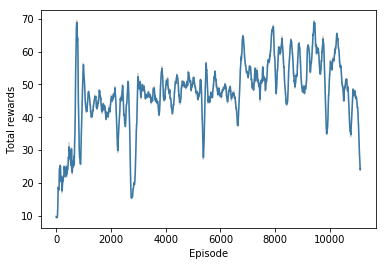

In [43]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

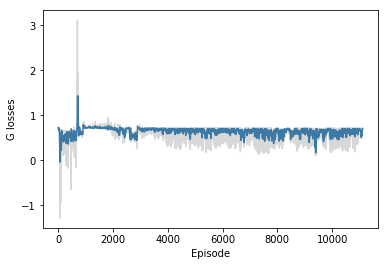

In [44]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

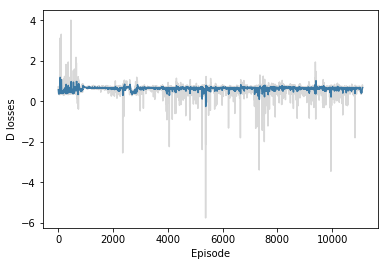

In [45]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [28]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        if total_reward == 500:
            break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model2.ckpt
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.